# Setting

In [12]:
import pandas as pd
import torch
import random
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import numpy as np

from perceiver import tokenize_data, CustomDataset, PerceiverBlock, Perceiver, CombinedModel

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

file_path = '/home/youlee/n24news/n24news/captions_and_labels.csv'
data = pd.read_csv(file_path)

groups = [
    ['Opinion', 'Food', 'Movies'],
    ['Art & Design', 'Science', 'Fashion & Style'],
    ['Television', 'Sports', 'Style'],
    ['Music', 'Health', 'Dance'],
    ['Real Estate', 'Books', 'Media'],
    ['Travel', 'Theater', 'Technology']
]

output_paths = []
for i, group_labels in enumerate(groups, 1):
    group_data = data[data['Label'].isin(group_labels)]
    output_path = f'/home/youlee/n24news/n24news/regroup_{i}.csv'
    group_data.to_csv(output_path, index=False)
    output_paths.append(output_path)

print("생성된 그룹별 CSV 파일 경로:")
for path in output_paths:
    print(path)

생성된 그룹별 CSV 파일 경로:
/home/youlee/n24news/n24news/regroup_1.csv
/home/youlee/n24news/n24news/regroup_2.csv
/home/youlee/n24news/n24news/regroup_3.csv
/home/youlee/n24news/n24news/regroup_4.csv
/home/youlee/n24news/n24news/regroup_5.csv
/home/youlee/n24news/n24news/regroup_6.csv


In [13]:
def seed_everything(seed):
    torch.manual_seed(seed) #torch를 거치는 모든 난수들의 생성순서를 고정한다
    torch.cuda.manual_seed(seed) #cuda를 사용하는 메소드들의 난수시드는 따로 고정해줘야한다 
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True #딥러닝에 특화된 CuDNN의 난수시드도 고정 
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed) #numpy를 사용할 경우 고정
    random.seed(seed) #파이썬 자체 모듈 random 모듈의 시드 고정
seed_everything(42)

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 128

In [15]:
# def tokenize_data(df):
#     input_ids, attention_masks = [], []
    
#     df['Caption'] = df['Caption'].astype(str).fillna("")

#     for text in df['Caption']:
#         encoded = tokenizer(
#             text, padding='max_length', truncation=True, max_length=MAX_LENGTH, return_tensors="pt"
#         )
#         input_ids.append(encoded['input_ids'].squeeze(0))
#         attention_masks.append(encoded['attention_mask'].squeeze(0))
#     return torch.stack(input_ids), torch.stack(attention_masks)

# class CustomDataset(Dataset):
#     def __init__(self, input_ids, attention_masks, labels):
#         self.input_ids = input_ids
#         self.attention_masks = attention_masks
#         self.labels = labels

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         return {
#             'input_ids': self.input_ids[idx],
#             'attention_mask': self.attention_masks[idx],
#             'labels': self.labels[idx]
#         }

# class PerceiverBlock(nn.Module):
  
#     def __init__(self, latent_dim, n_heads=8, self_attn_layers=1):
#         super().__init__()
        
#         self.cross_attn = nn.MultiheadAttention(embed_dim=latent_dim, num_heads=n_heads)
#         self.cross_ln = nn.LayerNorm(latent_dim)  # Layer Normalization

    
#         self.self_attn_layers = nn.ModuleList([
#             nn.TransformerEncoderLayer(d_model=latent_dim, nhead=n_heads)
#             for _ in range(self_attn_layers)
#         ])

#     def forward(self, latents, x):
#         # latents, x: (T, B, dim) 형태로 가정
#         # Perceiver 원리상 latents는 query, x는 key/value

       
#         updated_latents, _ = self.cross_attn(latents, x, x)
#         latents = latents + updated_latents       
#         latents = self.cross_ln(latents)        
  
#         for layer in self.self_attn_layers:
  
#            latents = layer(latents)  
#         return latents

# class Perceiver(nn.Module):
#     def __init__(self, input_dim, latent_dim, latent_size, num_classes,
#                  num_blocks, self_attn_layers_per_block=1):
#         super().__init__()
#         self.latents = nn.Parameter(torch.randn(latent_size, latent_dim))
#         self.input_projection = nn.Linear(input_dim, latent_dim)

#         # 여러 개의 PerceiverBlock을 쌓음
#         self.blocks = nn.ModuleList([
#             PerceiverBlock(
#                 latent_dim=latent_dim,
#                 n_heads=8,
#                 self_attn_layers=self_attn_layers_per_block
#             )
#             for _ in range(num_blocks)
#         ])

#         self.output_layer = nn.Linear(latent_dim, num_classes)

#     def forward(self, x):
#         """
#         x: (B, T, F) = (배치, 시퀀스 길이, 피처 차원)
#         """
#         B, T, F = x.size()
#         x = self.input_projection(x)                 # (B, T, latent_dim)

#         # latents: (latent_size, latent_dim) -> 배치 차원 확장 (B, latent_size, latent_dim)
#         latents = self.latents.unsqueeze(0).expand(B, -1, -1)

#         # MultiHeadAttention은 (T, B, dim) 순서를 권장하므로 permute
#         x = x.permute(1, 0, 2)        # (T, B, latent_dim)
#         latents = latents.permute(1, 0, 2)  # (latent_size, B, latent_dim)

#         # PerceiverBlock을 여러 번 반복
#         for block in self.blocks:
#             latents = block(latents, x)

#         # 최종 latents: (latent_size, B, latent_dim)
#         latents = latents.permute(1, 0, 2).mean(dim=1)  # (B, latent_dim)
#         return self.output_layer(latents)

# class CombinedModel(nn.Module):
#     def __init__(self, vocab_size, embed_dim, perceiver_model):
#         super().__init__()
#         self.embedding = nn.Embedding(vocab_size, embed_dim)
#         self.perceiver = perceiver_model

#     def forward(self, input_ids):
#         embeddings = self.embedding(input_ids)  # (B, T, embed_dim)
#         return self.perceiver(embeddings)  


# Functions

In [16]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)  
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)  # CombinedModel의 forward 호출
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)  
            labels = batch['labels'].to(device)

            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [17]:
model_path = '/home/Minju/Perceiver/model'
loader_path = '/home/Minju/Perceiver/loader'

In [18]:
# for idx, group_file in enumerate(output_paths, start=1):
#     print(f"\ngroup {idx} 처리 중...")

#     df = pd.read_csv(group_file)
#     label_encoder = LabelEncoder()
#     df['Label'] = label_encoder.fit_transform(df['Label'])
#     num_classes = len(label_encoder.classes_)

#     input_ids, attention_masks = tokenize_data(df, tokenizer=tokenizer, MAX_LENGTH=MAX_LENGTH)
#     labels = torch.tensor(df['Label'].values)

#     dataset = CustomDataset(input_ids, attention_masks, labels)
#     sample = dataset [0]
#     print(sample)
#     print(len(dataset)) 

#     dataloader = DataLoader(dataset, batch_size=2, shuffle=False)
#     first_batch = next(iter(dataloader))
#     print(first_batch)
 

# Train 시작


group 1 처리 중...

  fold 1/5 처리 중...
    epoch 1/15: train loss: 0.9749, train acc: 0.4781
                               test loss: 0.6523, test acc: 0.7365
    epoch 5/15: train loss: 0.1979, train acc: 0.9375
                               test loss: 0.4644, test acc: 0.8460
    epoch 10/15: train loss: 0.0630, train acc: 0.9814
                               test loss: 0.7601, test acc: 0.8433
    epoch 15/15: train loss: 0.0128, train acc: 0.9979
                               test loss: 0.9643, test acc: 0.8454

  fold 2/5 처리 중...
    epoch 1/15: train loss: 0.9967, train acc: 0.4704
                               test loss: 0.6661, test acc: 0.7259
    epoch 5/15: train loss: 0.2146, train acc: 0.9291
                               test loss: 0.3891, test acc: 0.8716
    epoch 10/15: train loss: 0.0581, train acc: 0.9856
                               test loss: 0.6620, test acc: 0.8702
    epoch 15/15: train loss: 0.0273, train acc: 0.9948
                               test lo

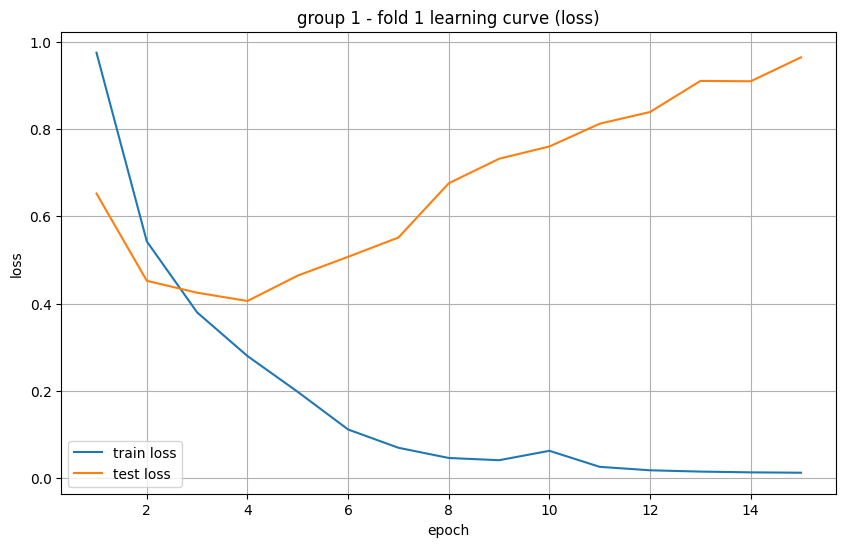

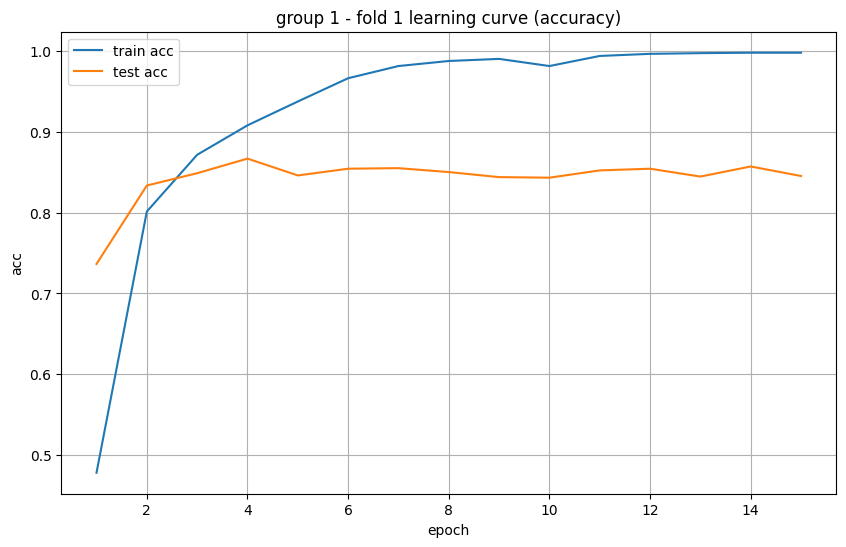

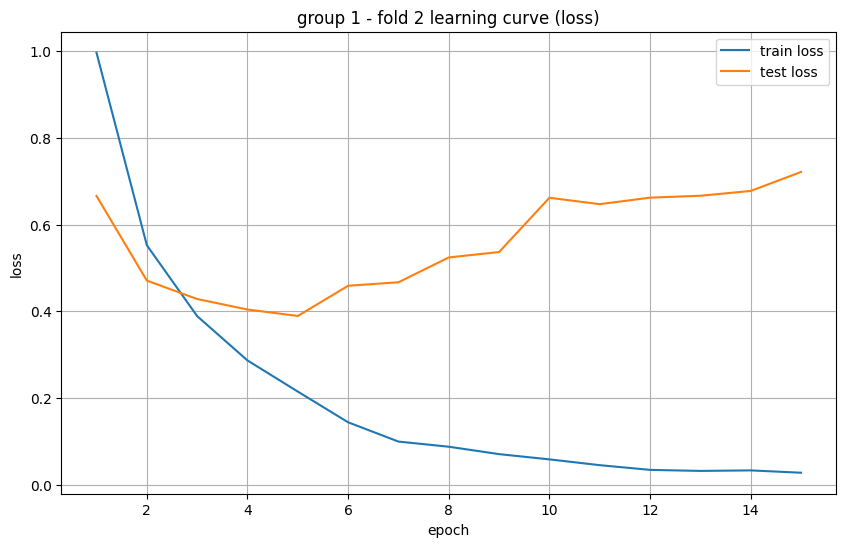

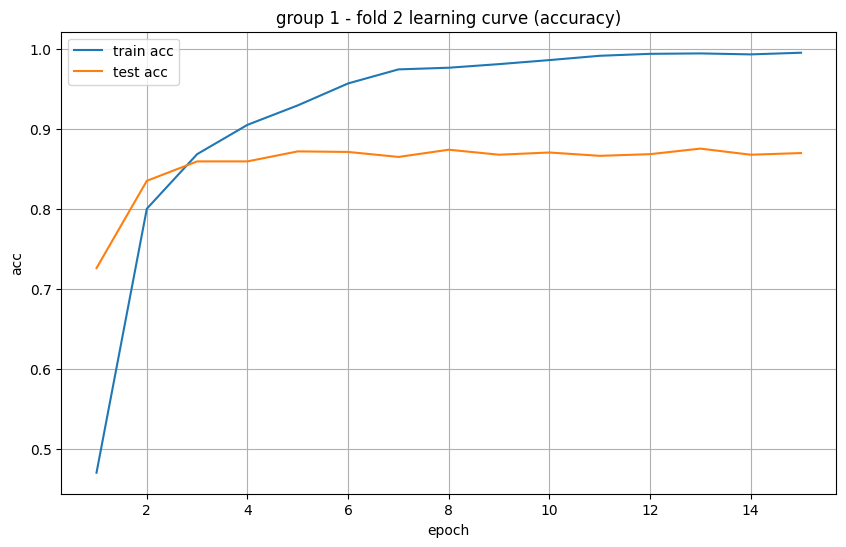

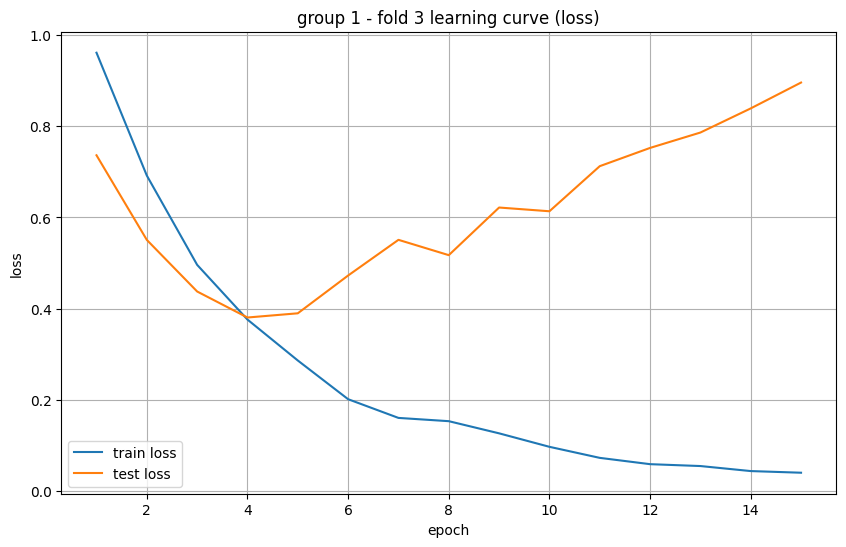

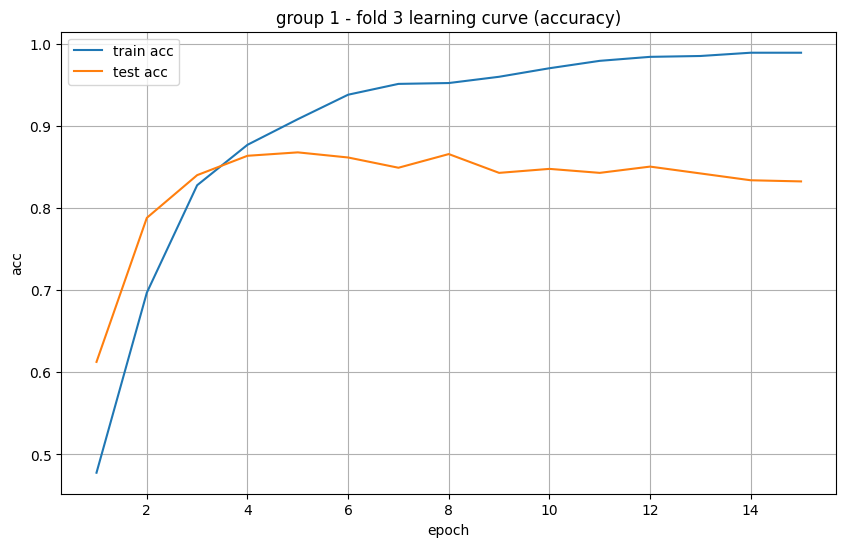

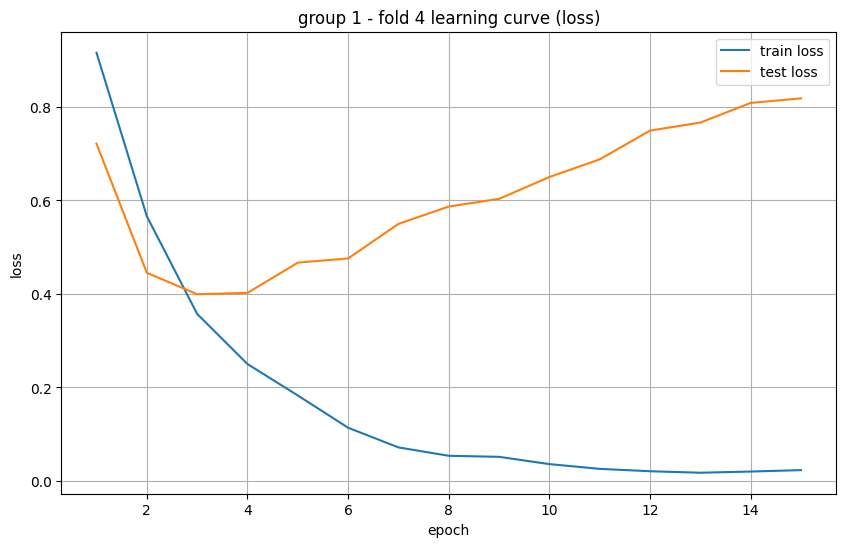

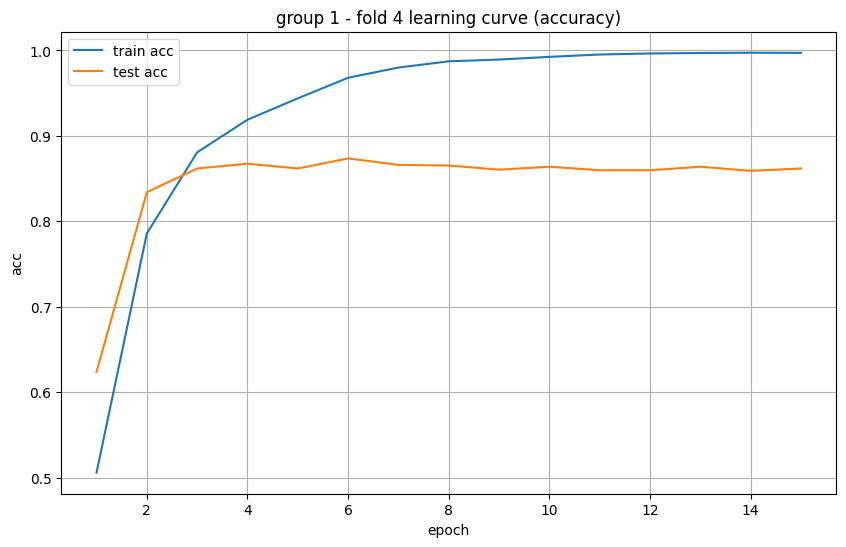

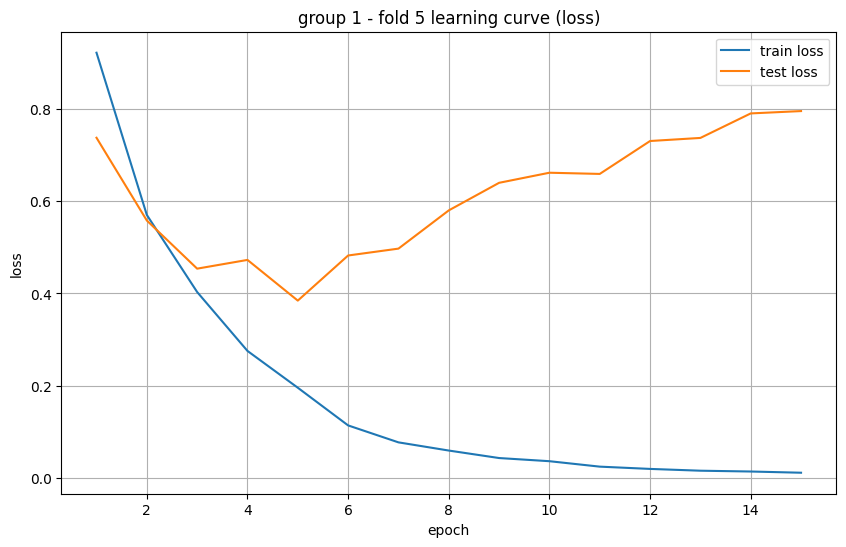

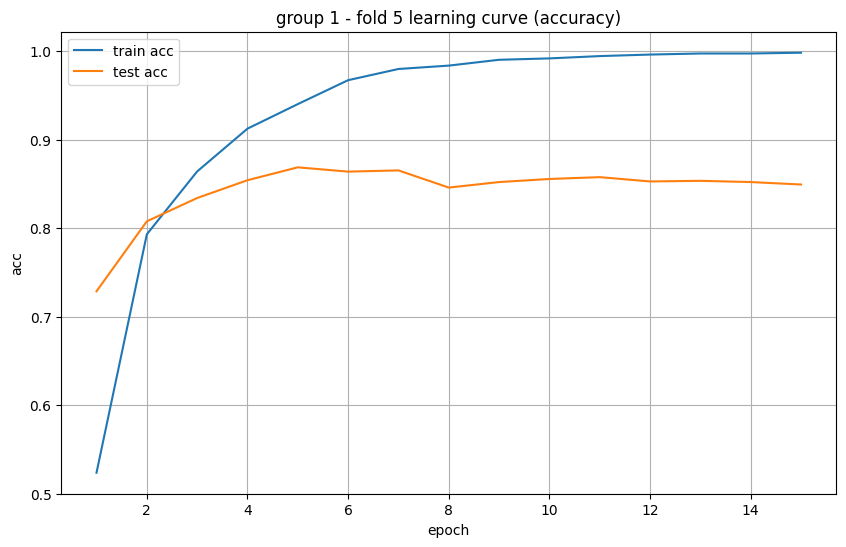

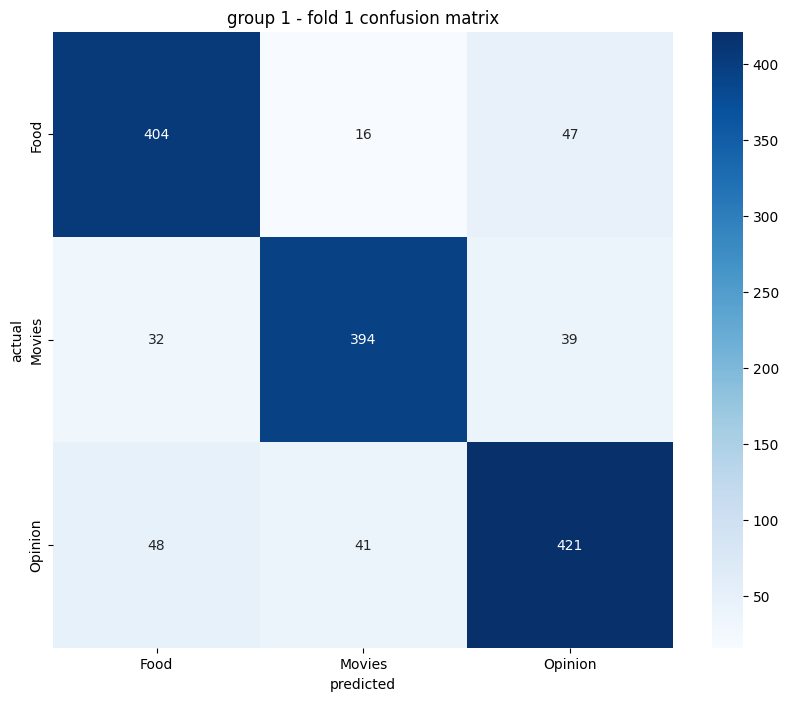

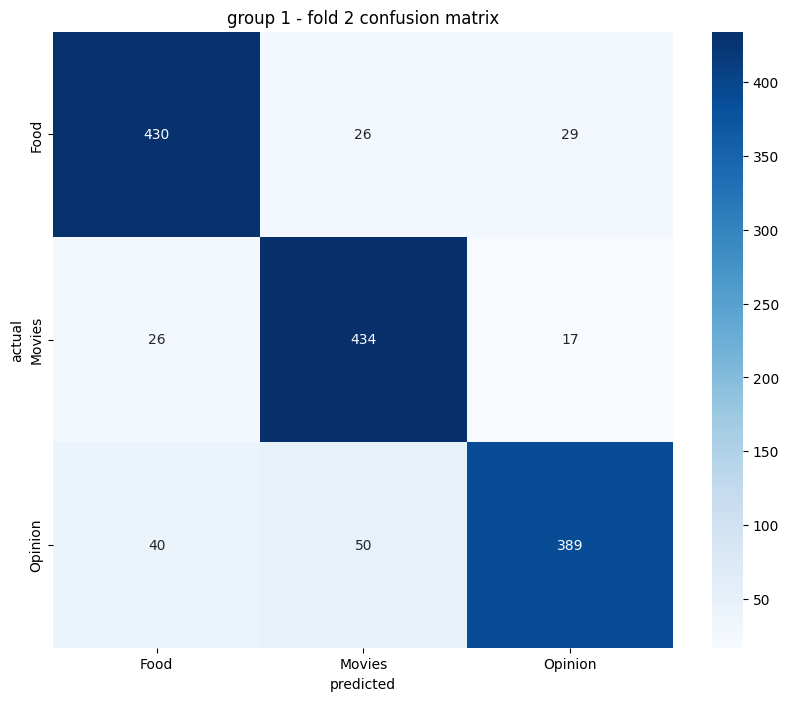

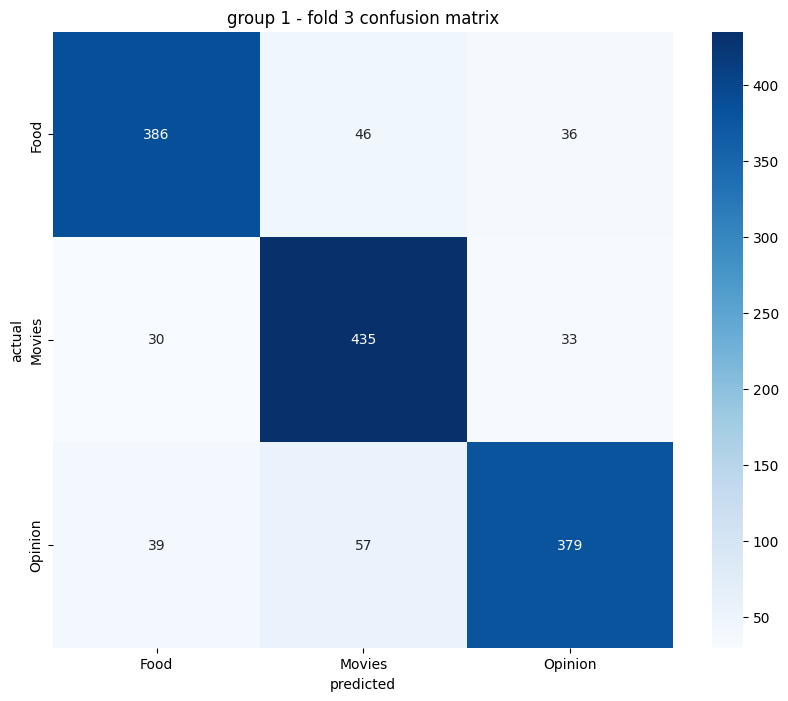

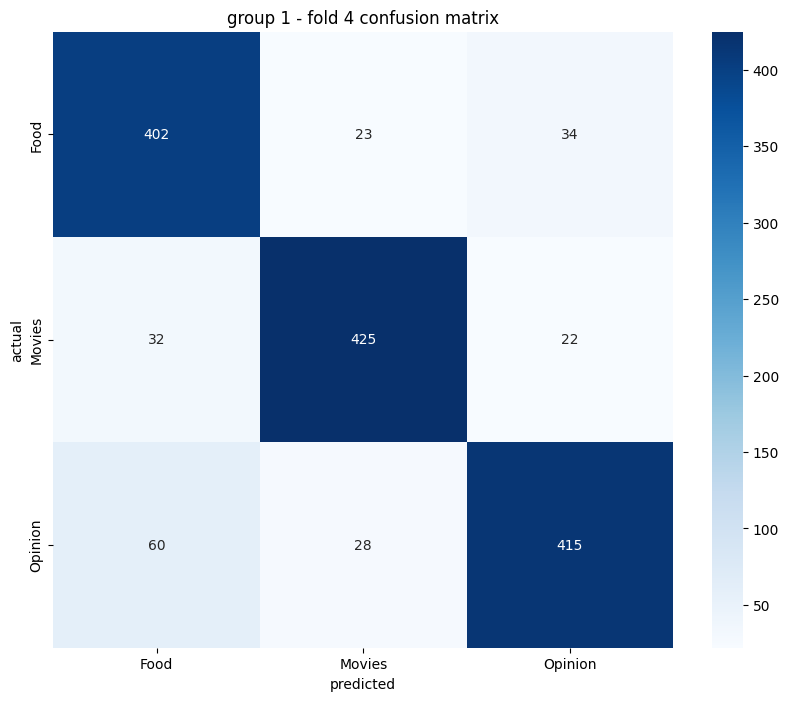

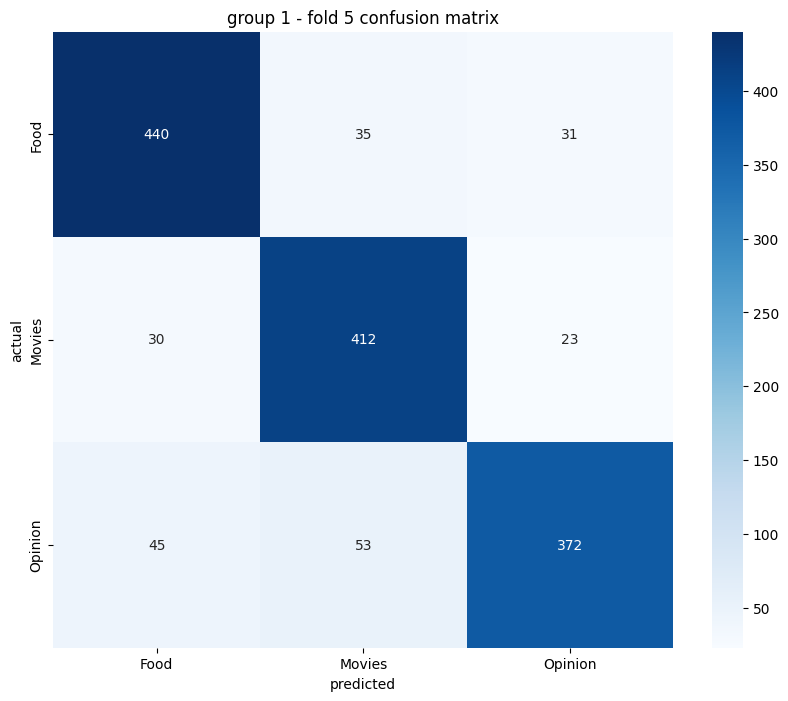


group 2 처리 중...

  fold 1/5 처리 중...
    epoch 1/15: train loss: 0.9921, train acc: 0.4988
                               test loss: 0.8144, test acc: 0.6530
    epoch 5/15: train loss: 0.2955, train acc: 0.8959
                               test loss: 0.5161, test acc: 0.8189
    epoch 10/15: train loss: 0.0507, train acc: 0.9865
                               test loss: 0.8857, test acc: 0.8147
    epoch 15/15: train loss: 0.0162, train acc: 0.9972
                               test loss: 1.0953, test acc: 0.8064

  fold 2/5 처리 중...
    epoch 1/15: train loss: 0.9721, train acc: 0.5014
                               test loss: 0.7980, test acc: 0.6454
    epoch 5/15: train loss: 0.2801, train acc: 0.9023
                               test loss: 0.6345, test acc: 0.7856
    epoch 10/15: train loss: 0.0535, train acc: 0.9851
                               test loss: 0.9524, test acc: 0.7953
    epoch 15/15: train loss: 0.0170, train acc: 0.9965
                               test lo

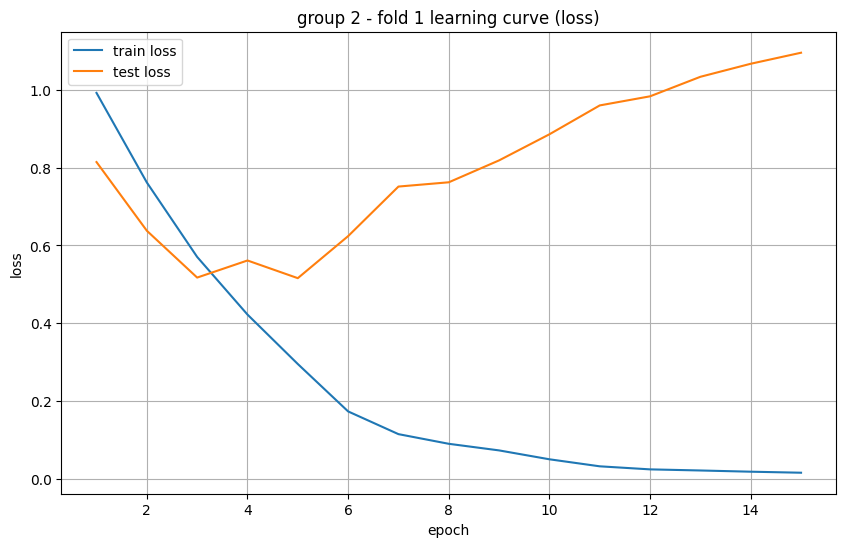

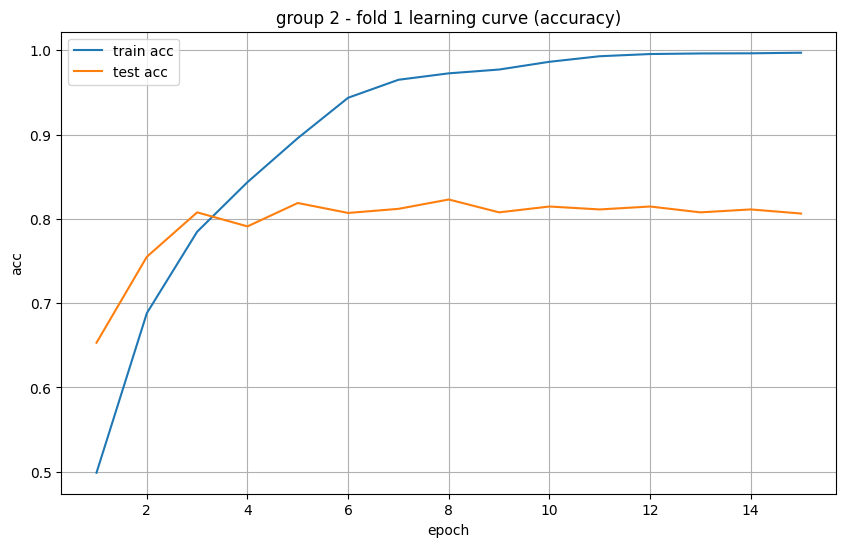

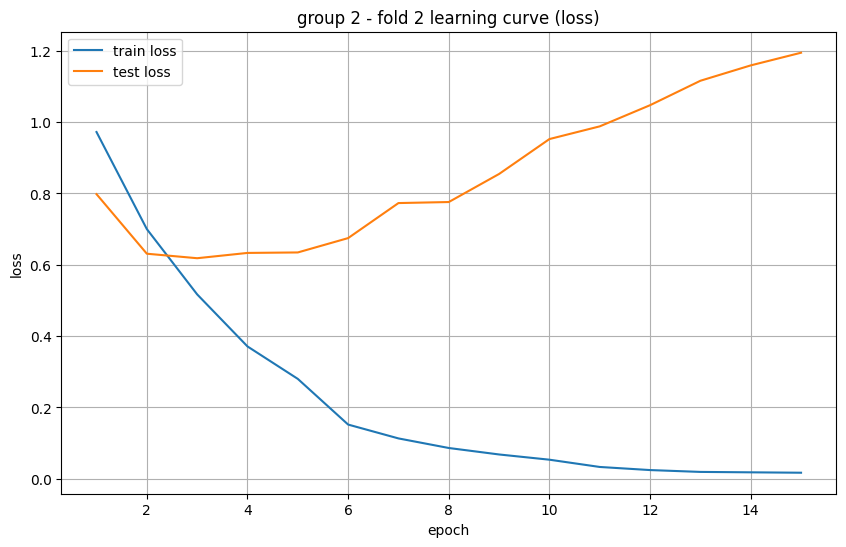

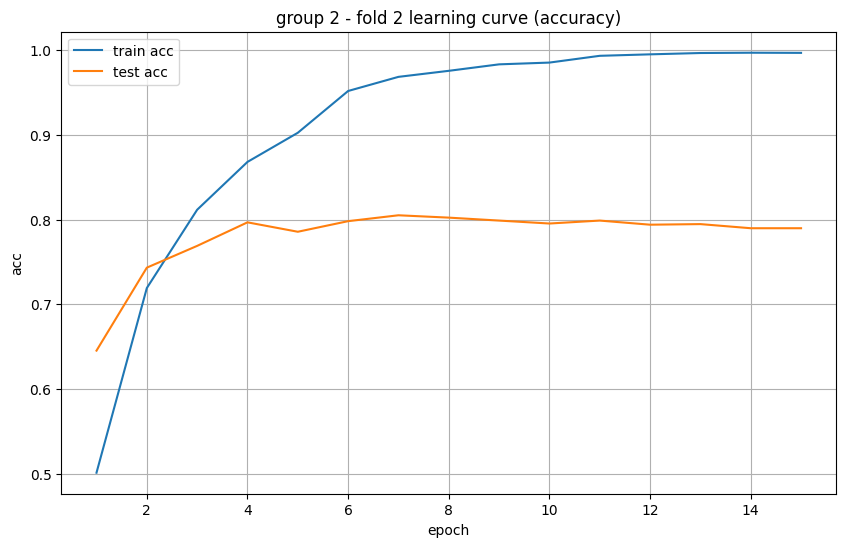

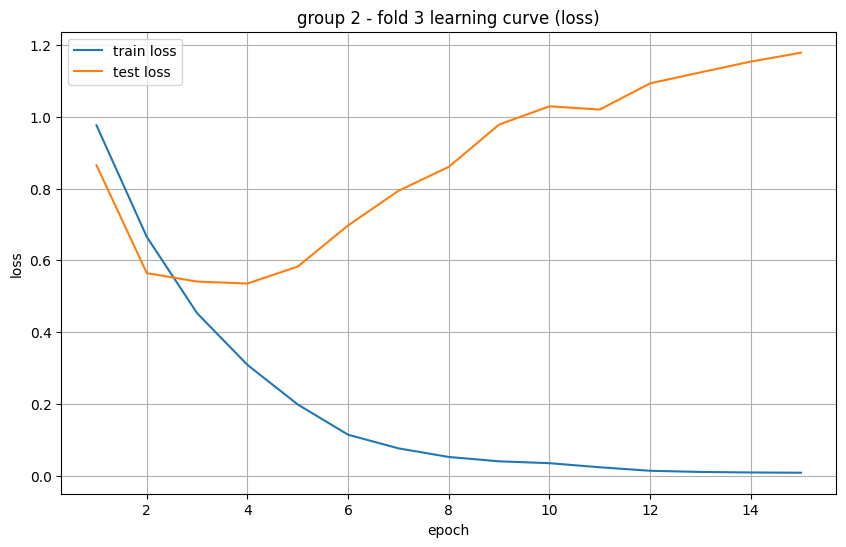

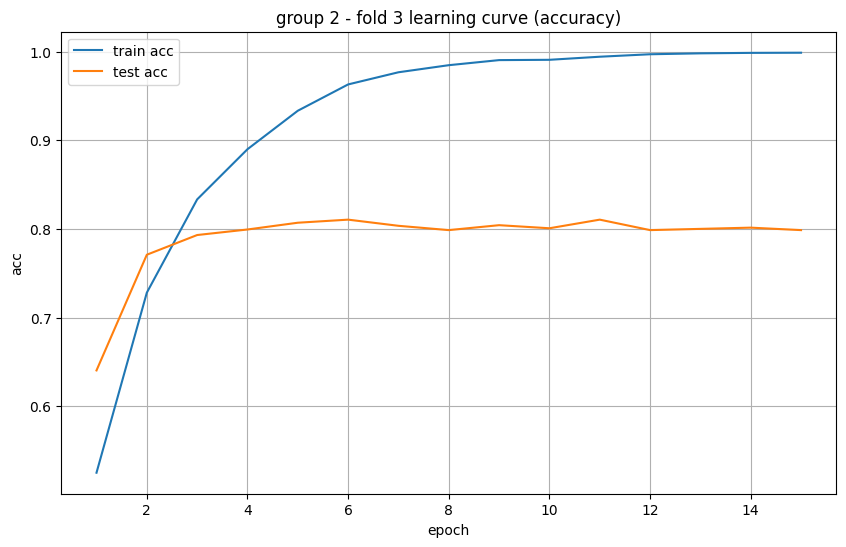

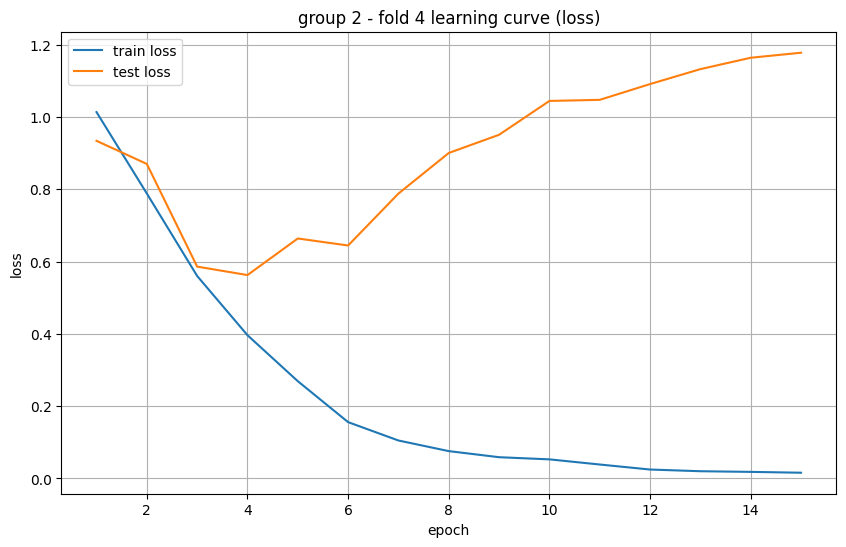

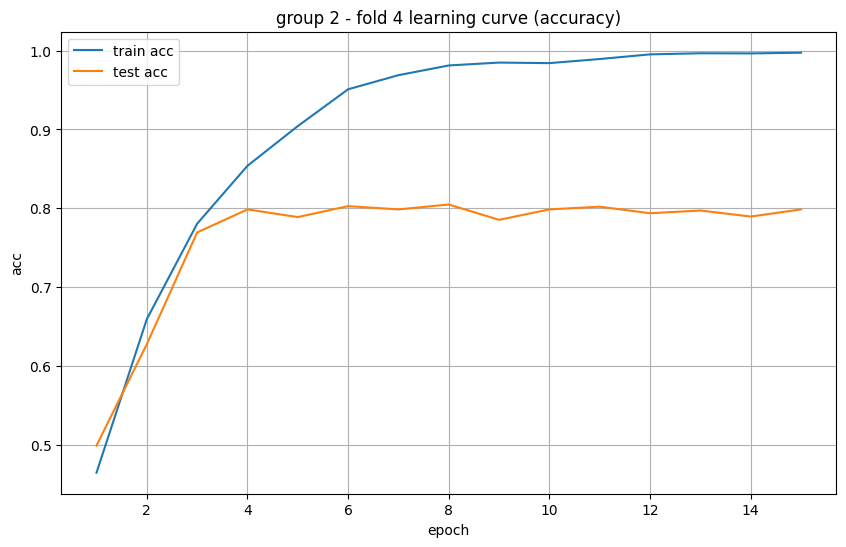

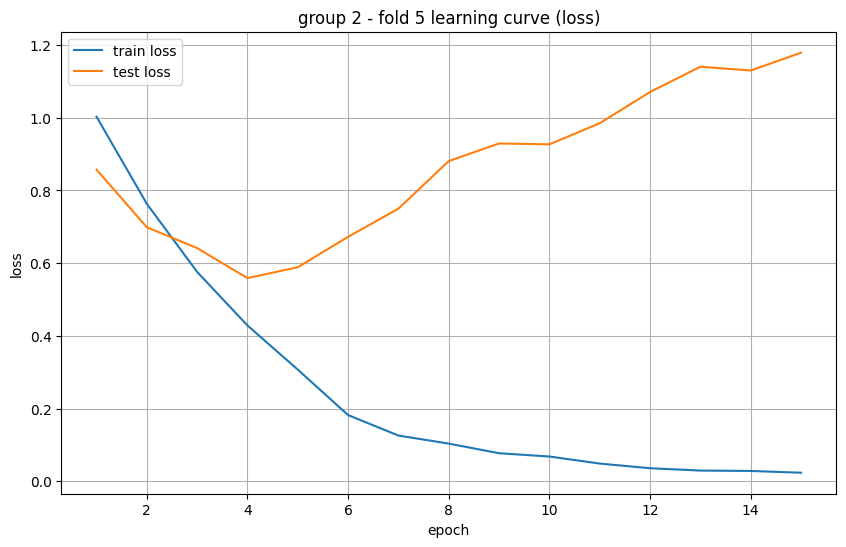

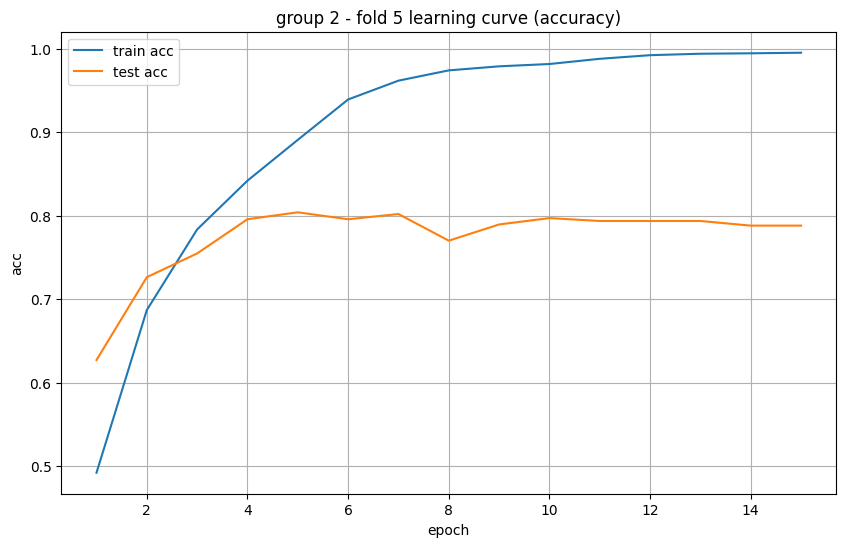

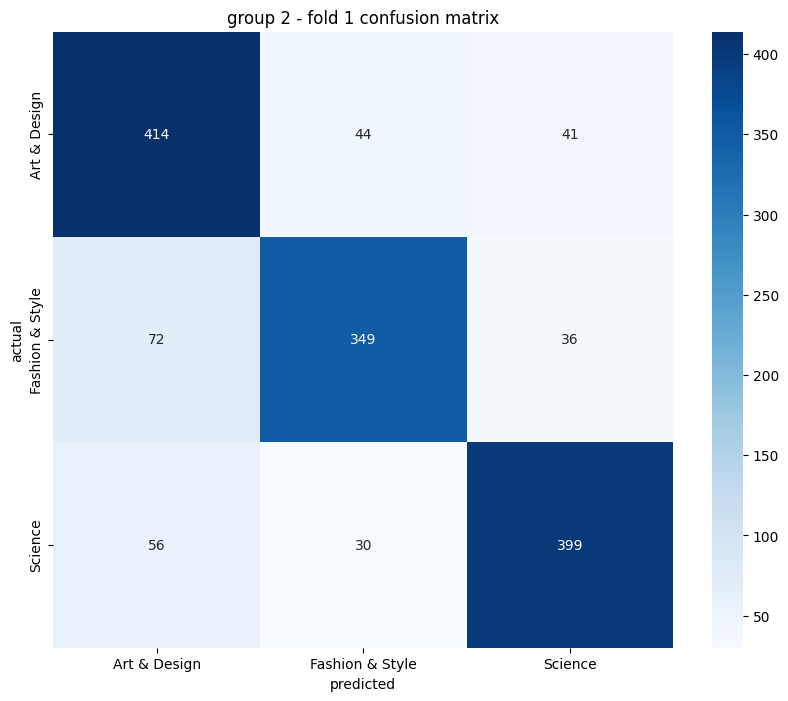

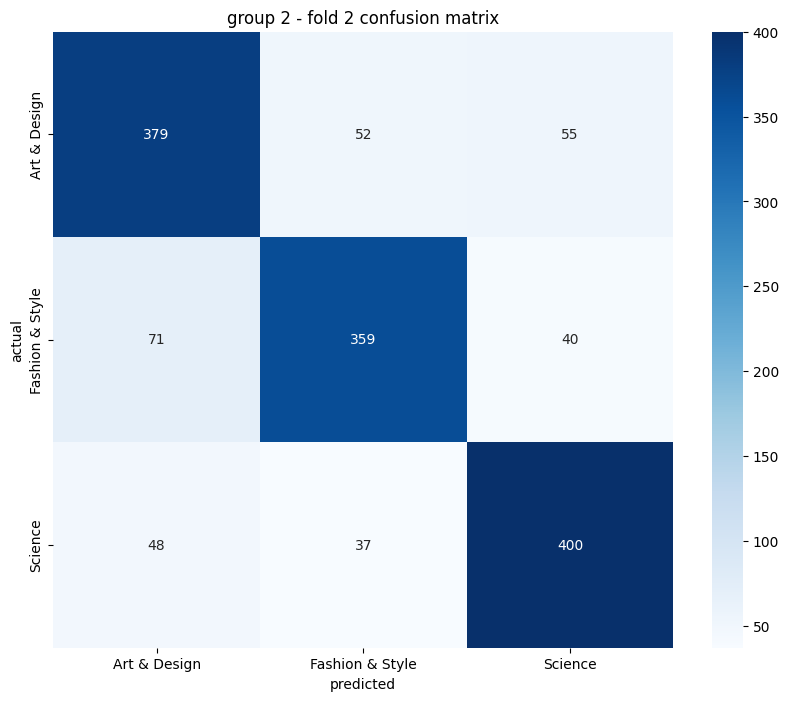

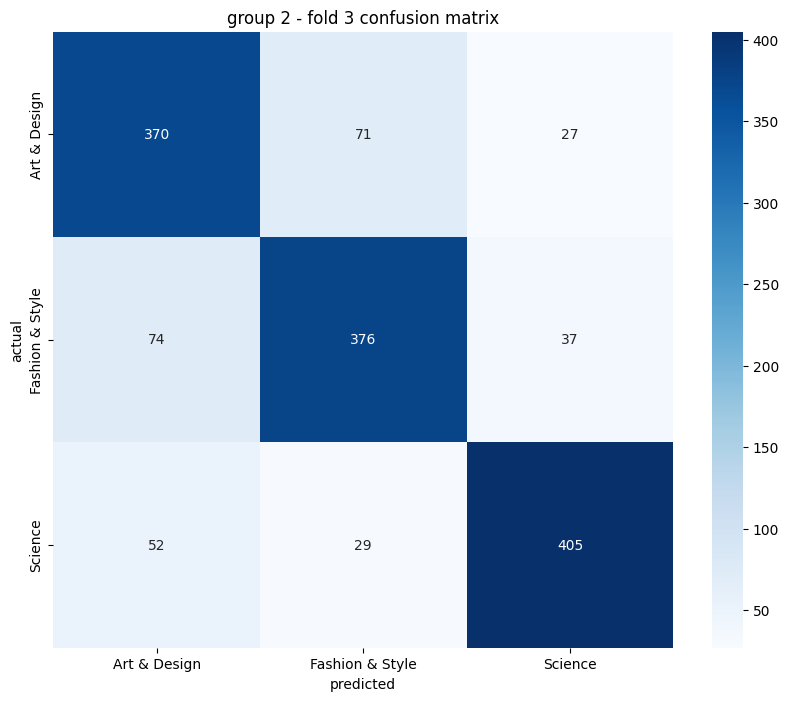

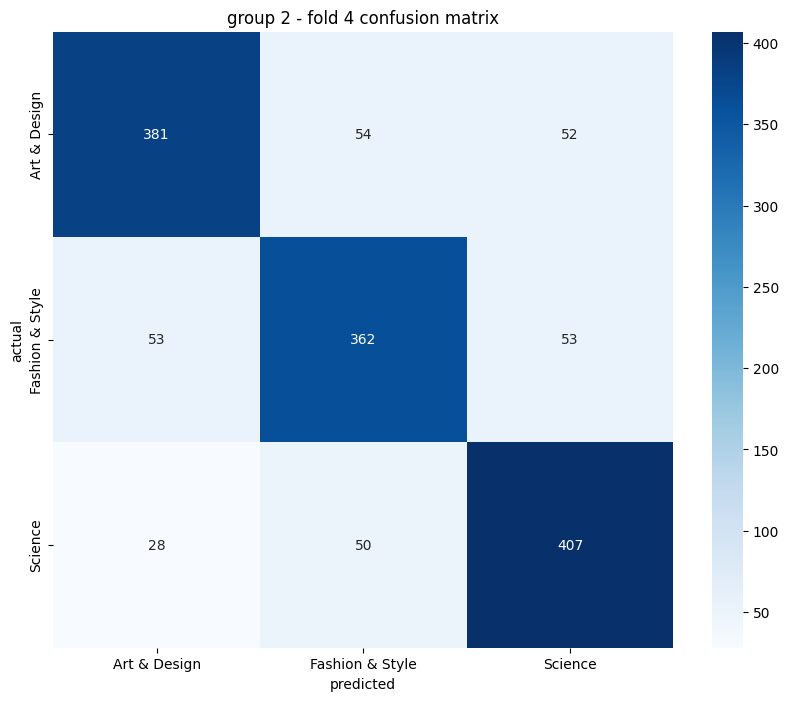

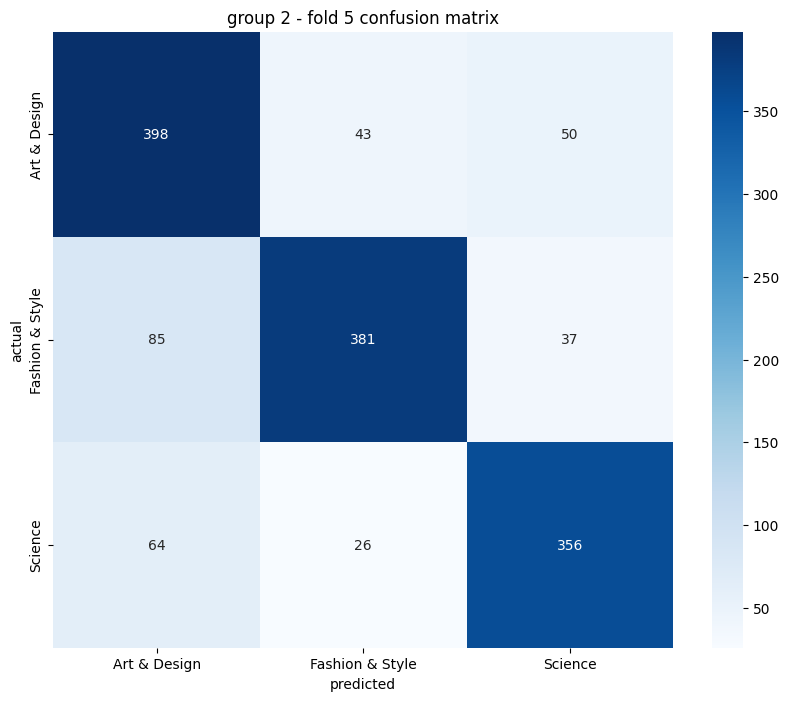


group 3 처리 중...

  fold 1/5 처리 중...
    epoch 1/15: train loss: 1.0509, train acc: 0.4321
                               test loss: 0.9428, test acc: 0.5642
    epoch 5/15: train loss: 0.2674, train acc: 0.9043
                               test loss: 0.4547, test acc: 0.8229
    epoch 10/15: train loss: 0.0574, train acc: 0.9833
                               test loss: 0.6847, test acc: 0.8315
    epoch 15/15: train loss: 0.0173, train acc: 0.9970
                               test loss: 0.9429, test acc: 0.8165

  fold 2/5 처리 중...
    epoch 1/15: train loss: 1.0352, train acc: 0.4426
                               test loss: 0.8896, test acc: 0.5778
    epoch 5/15: train loss: 0.2653, train acc: 0.9087
                               test loss: 0.4756, test acc: 0.8265
    epoch 10/15: train loss: 0.0451, train acc: 0.9898
                               test loss: 0.8124, test acc: 0.8172
    epoch 15/15: train loss: 0.0122, train acc: 0.9984
                               test lo

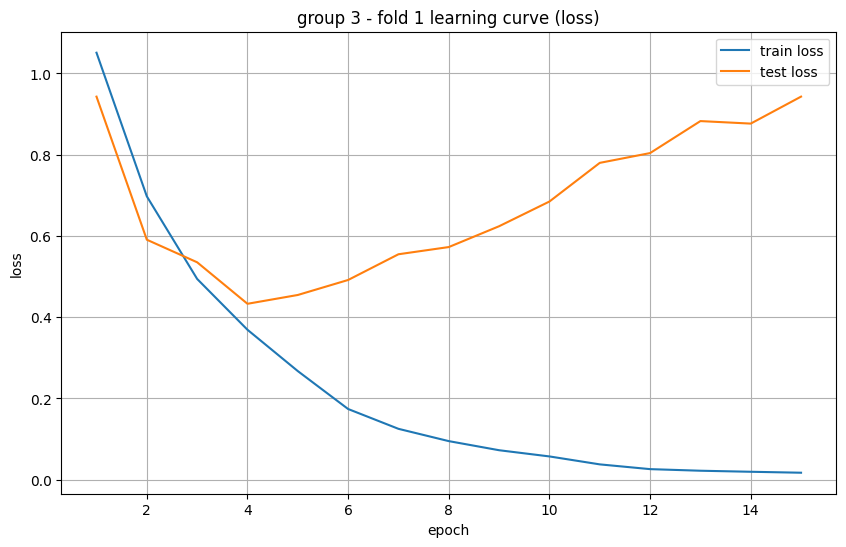

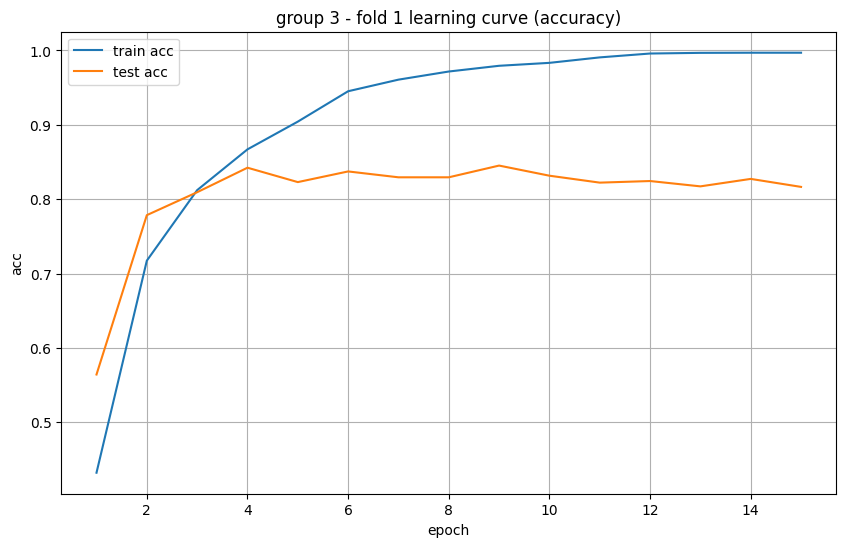

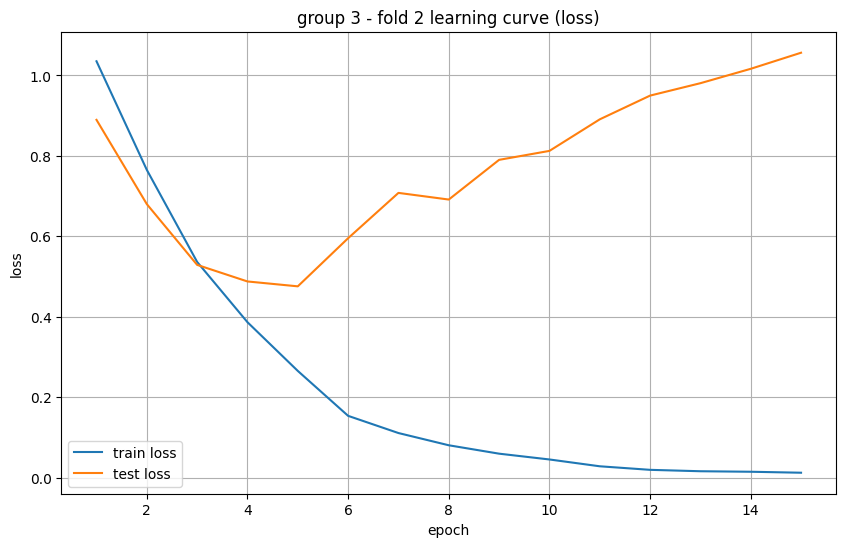

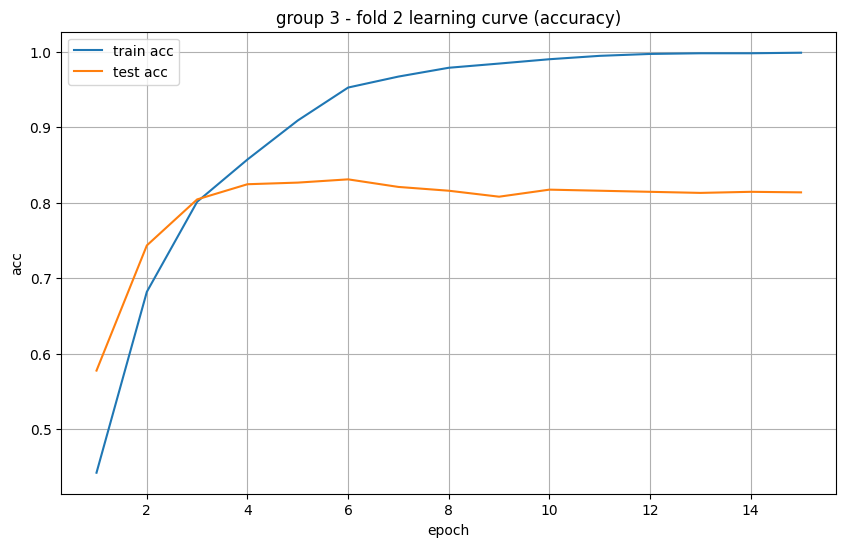

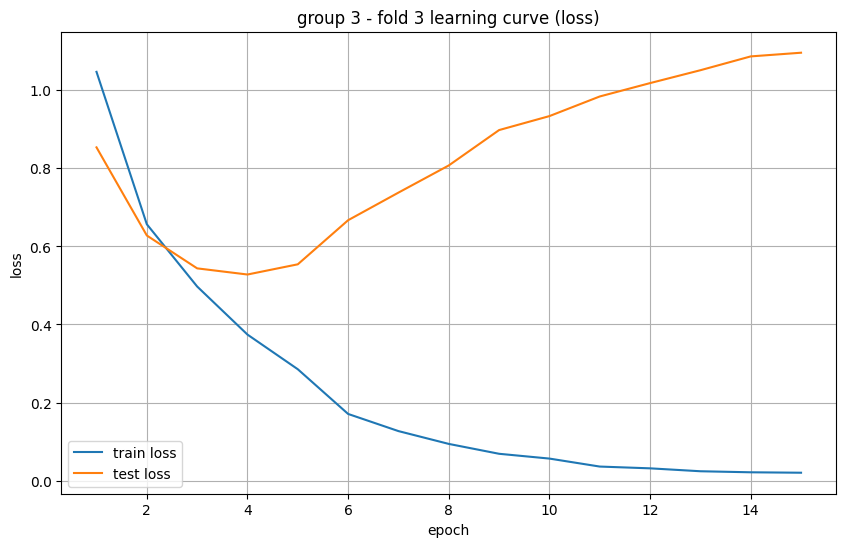

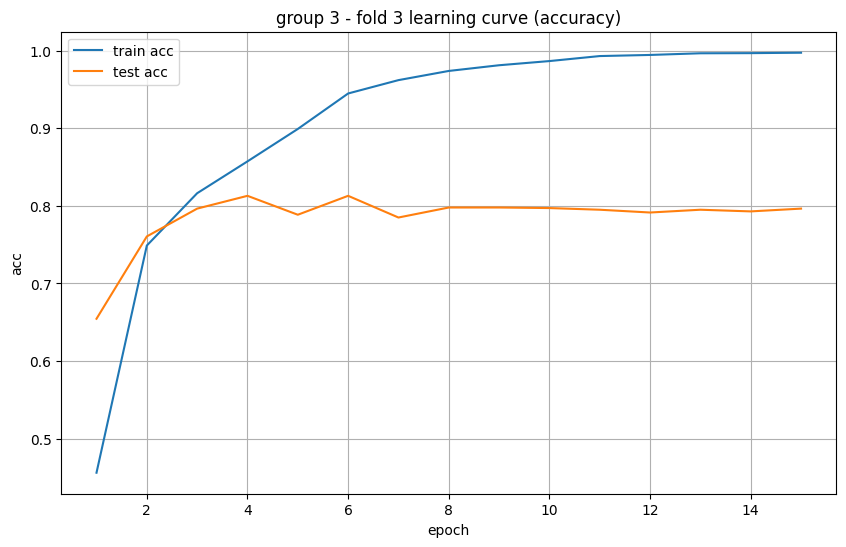

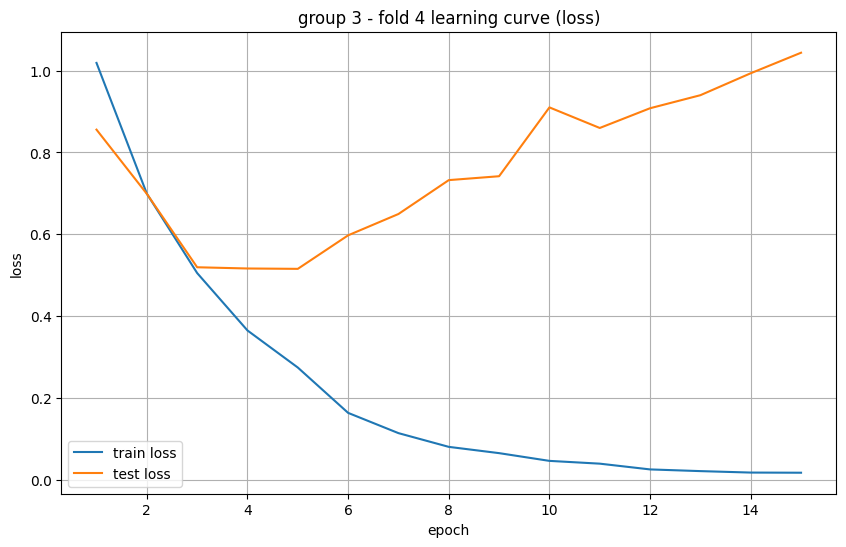

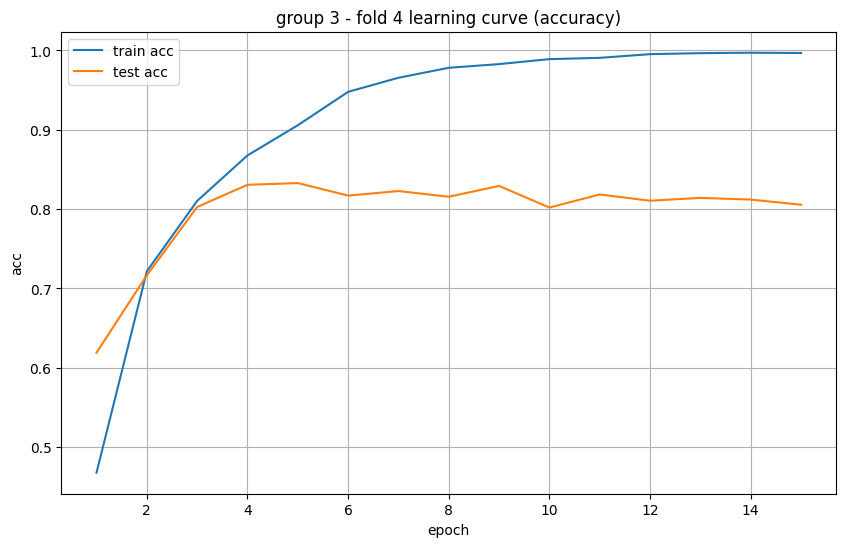

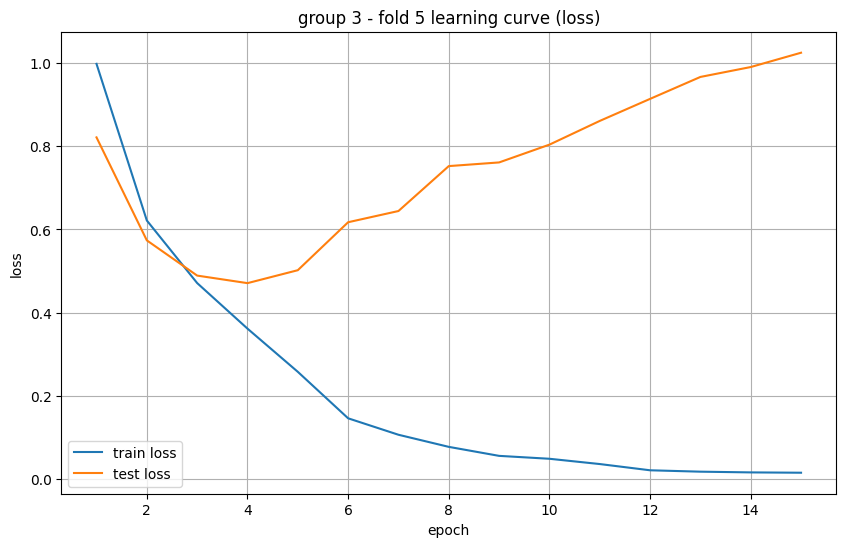

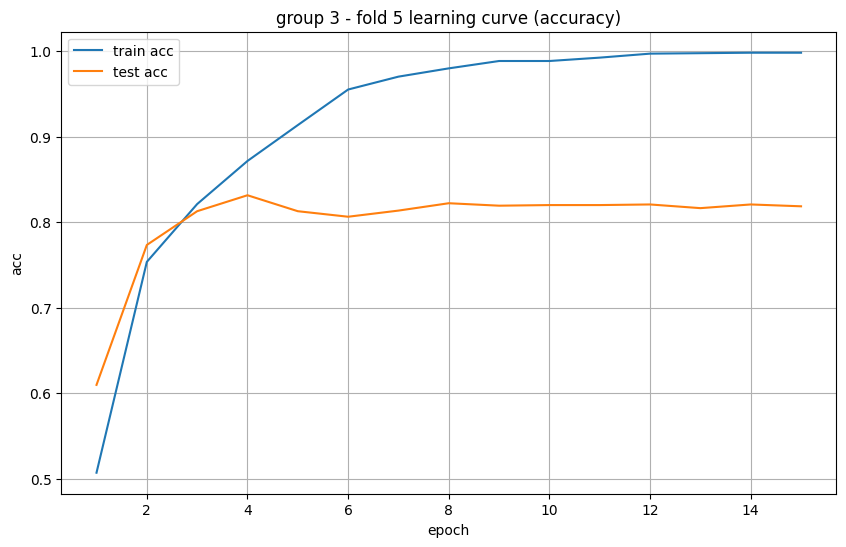

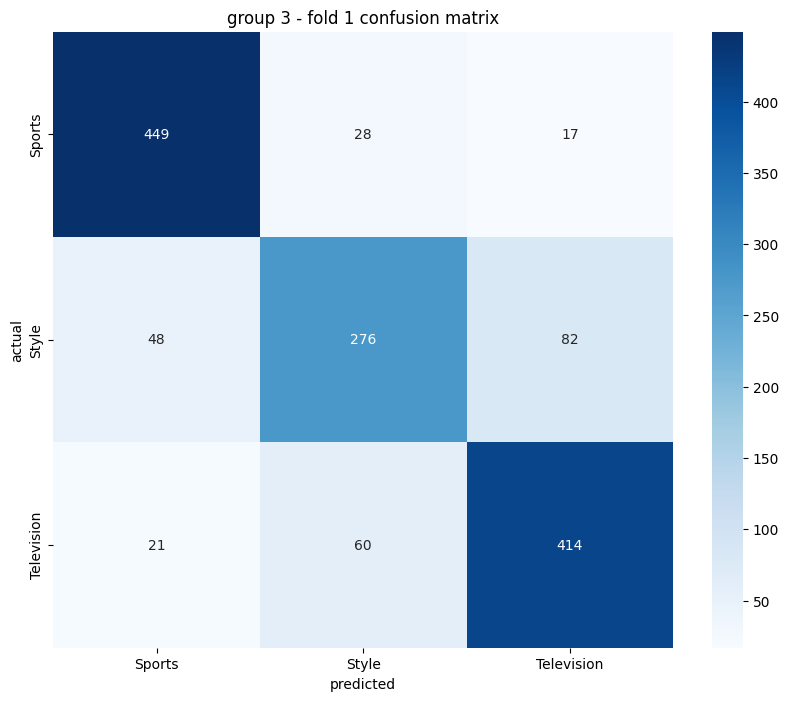

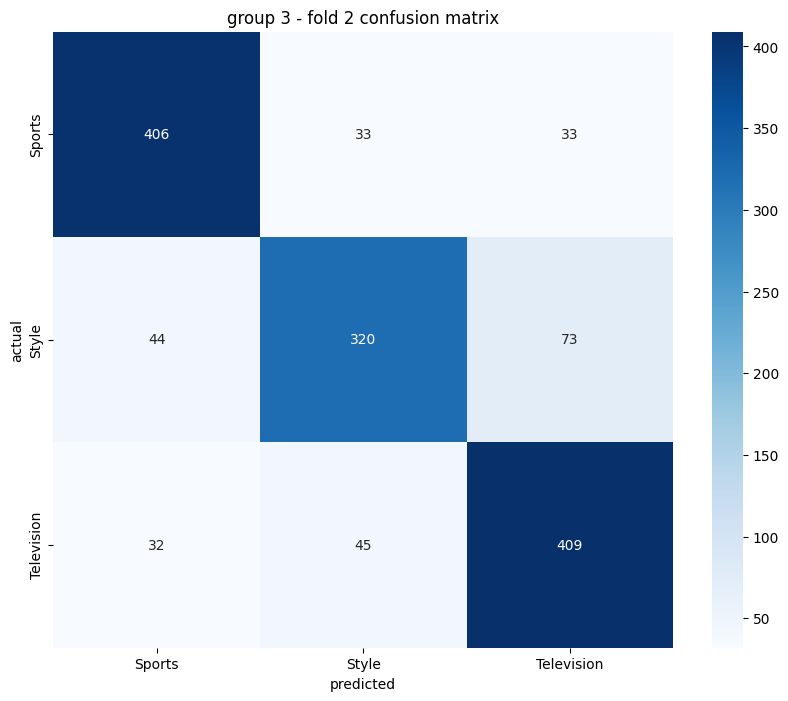

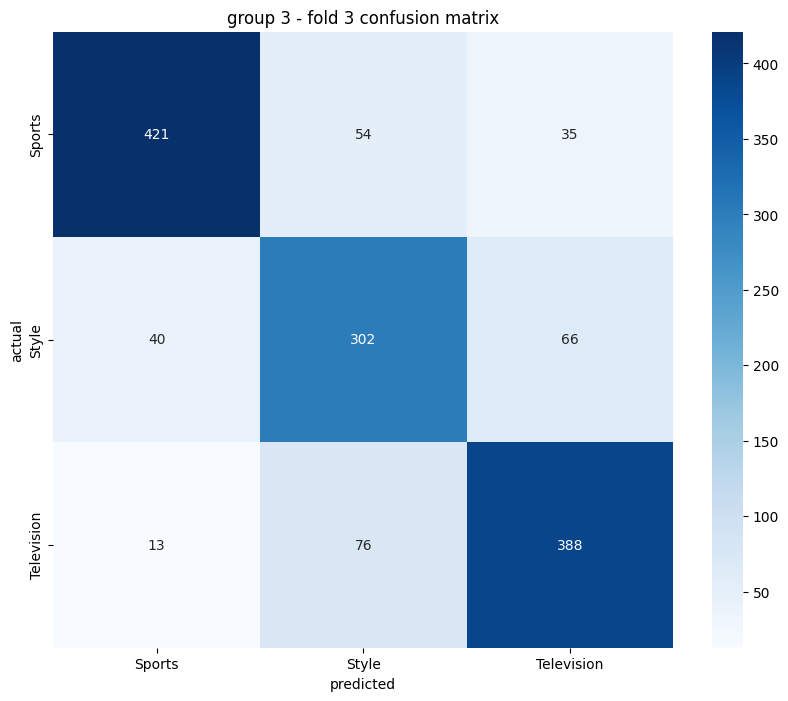

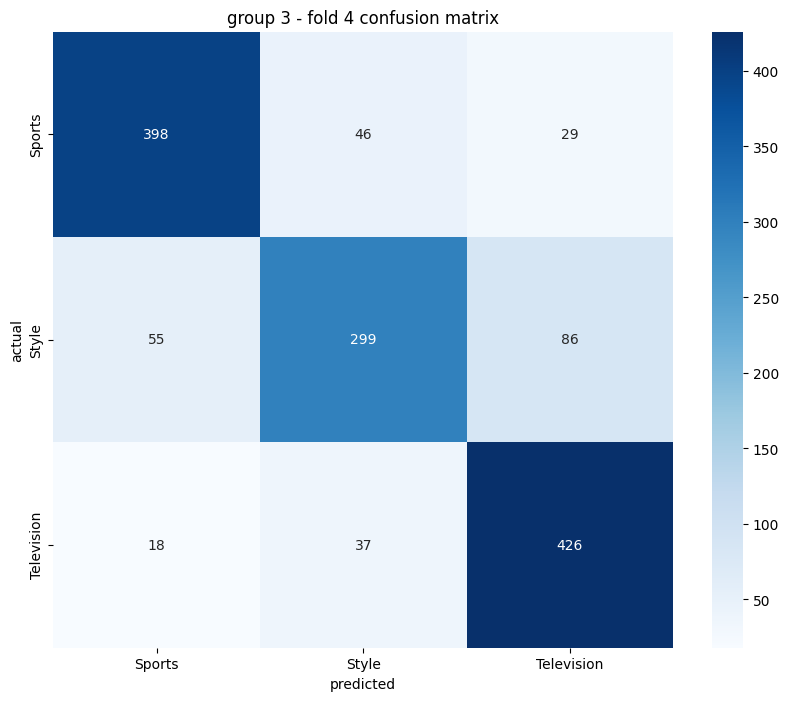

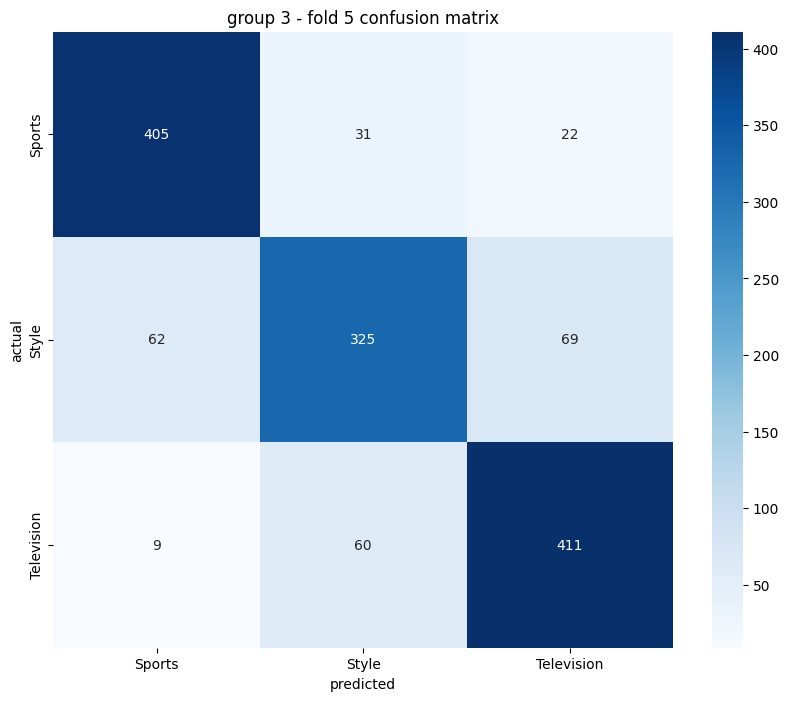


group 4 처리 중...

  fold 1/5 처리 중...
    epoch 1/15: train loss: 0.9837, train acc: 0.4870
                               test loss: 0.7316, test acc: 0.6530
    epoch 5/15: train loss: 0.1449, train acc: 0.9529
                               test loss: 0.4154, test acc: 0.8790
    epoch 10/15: train loss: 0.0232, train acc: 0.9943
                               test loss: 0.6216, test acc: 0.8734
    epoch 15/15: train loss: 0.0049, train acc: 0.9995
                               test loss: 0.6757, test acc: 0.8846

  fold 2/5 처리 중...
    epoch 1/15: train loss: 1.1145, train acc: 0.3576
                               test loss: 0.9621, test acc: 0.5640
    epoch 5/15: train loss: 0.1391, train acc: 0.9520
                               test loss: 0.4011, test acc: 0.8776
    epoch 10/15: train loss: 0.0255, train acc: 0.9943
                               test loss: 0.6296, test acc: 0.8755
    epoch 15/15: train loss: 0.0117, train acc: 0.9979
                               test lo

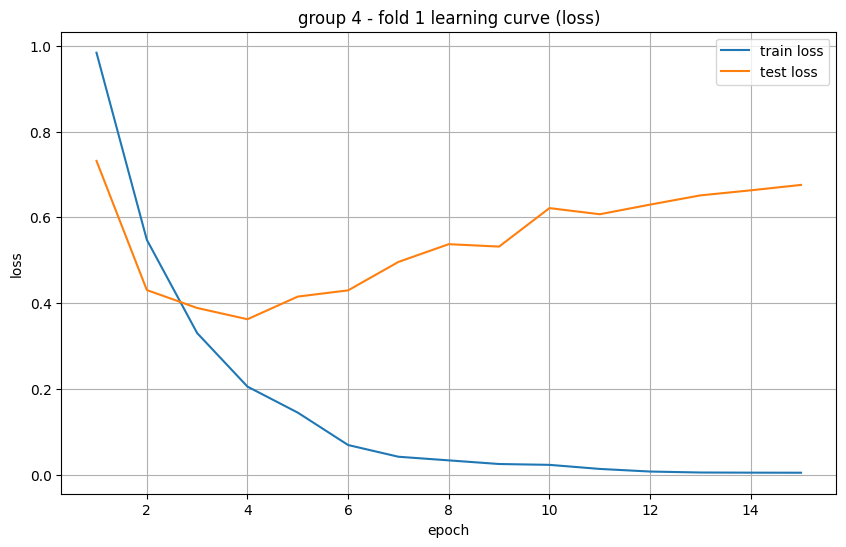

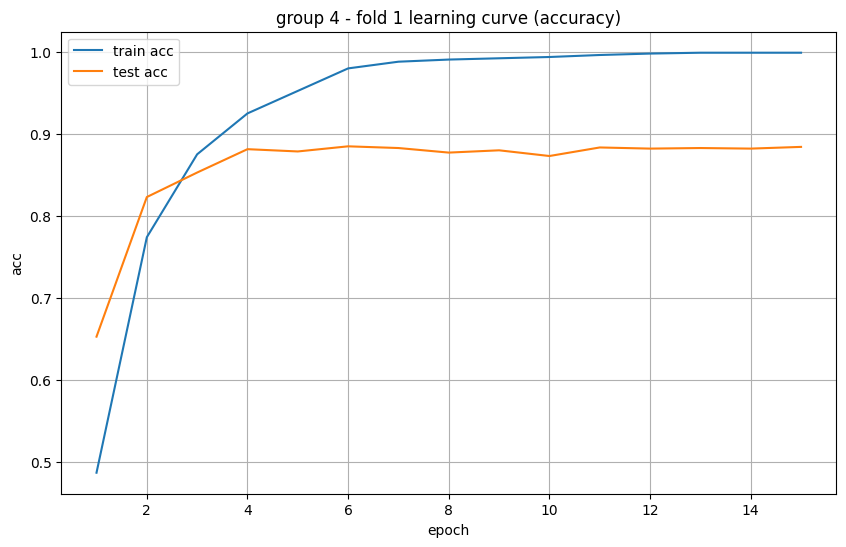

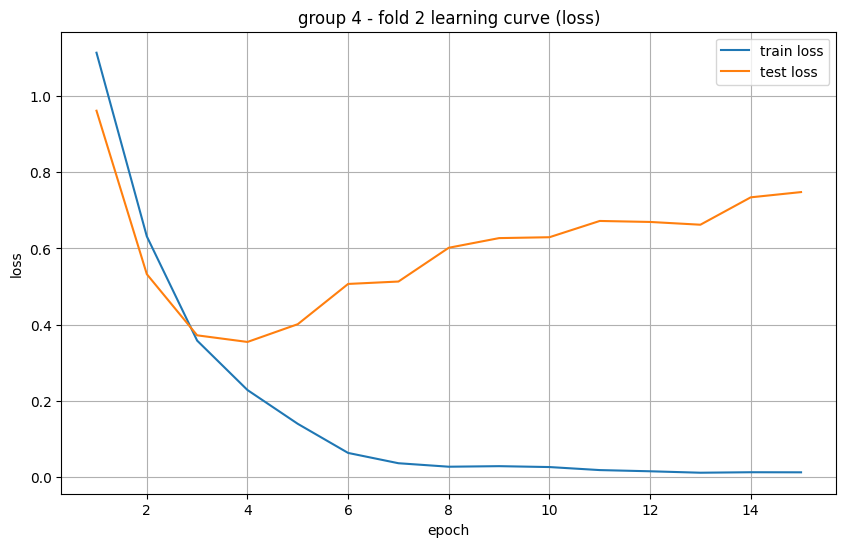

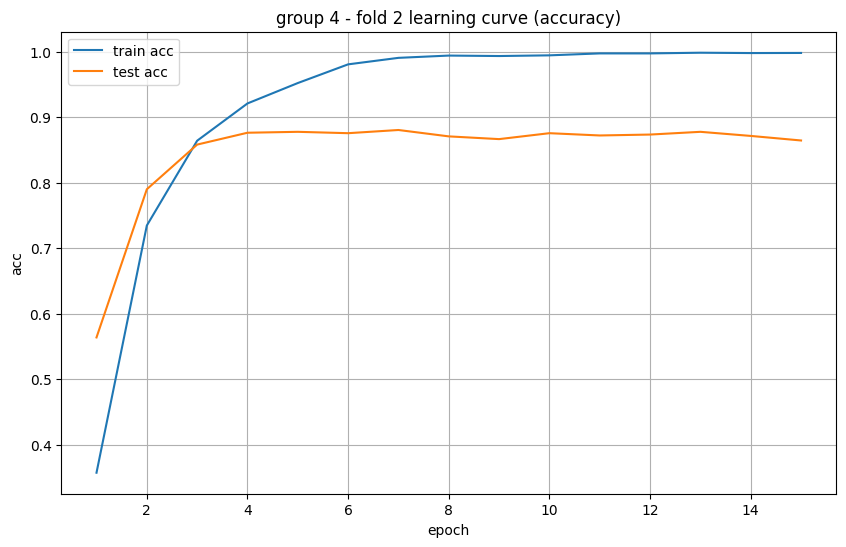

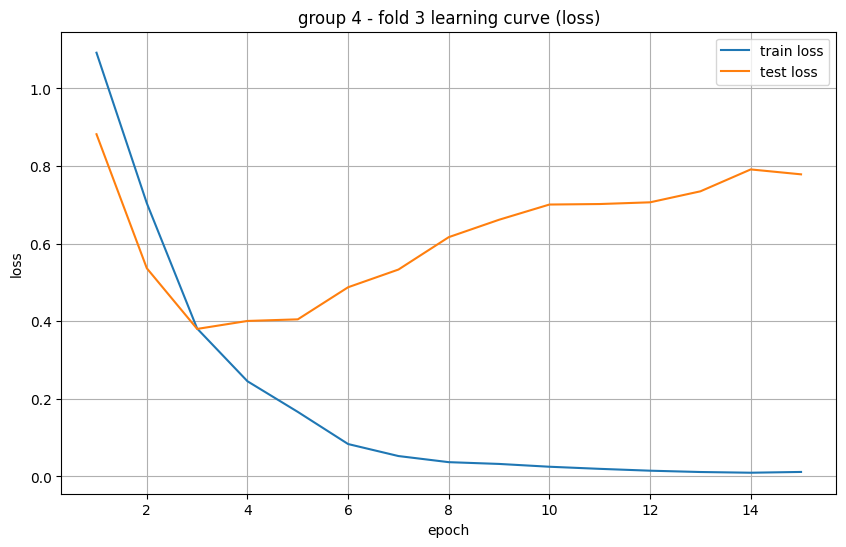

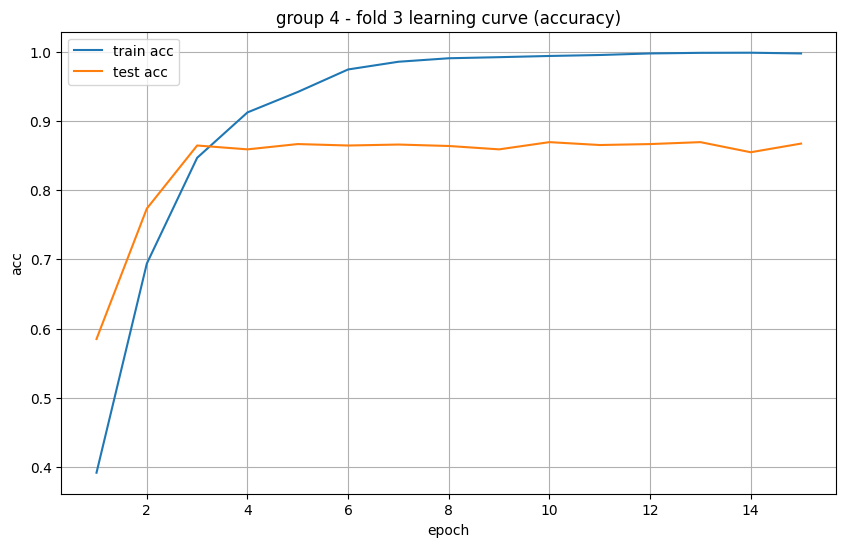

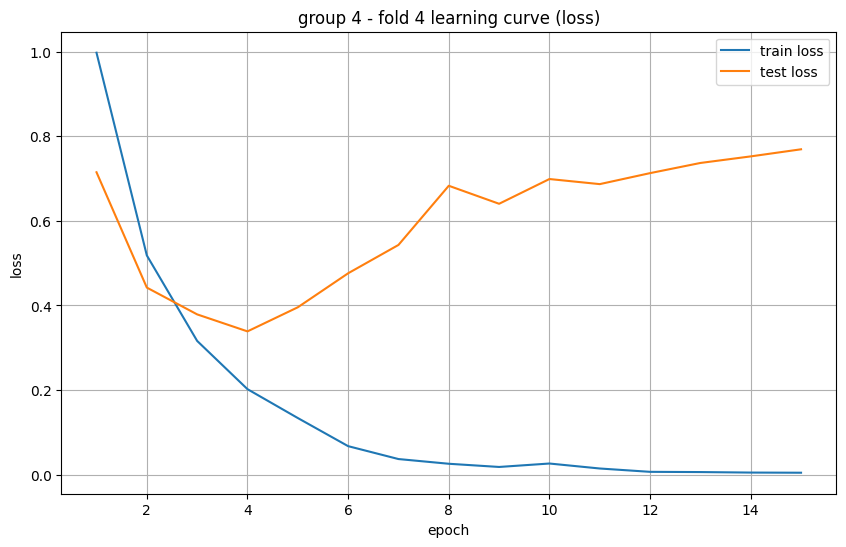

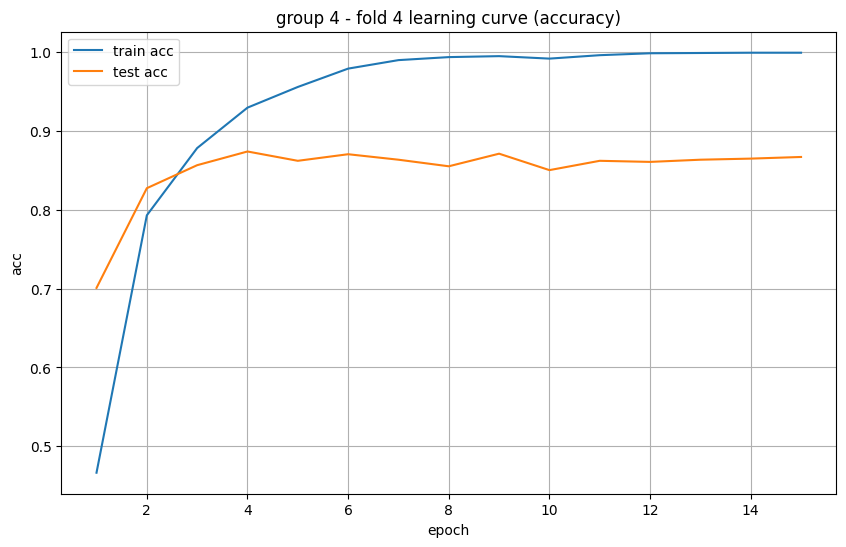

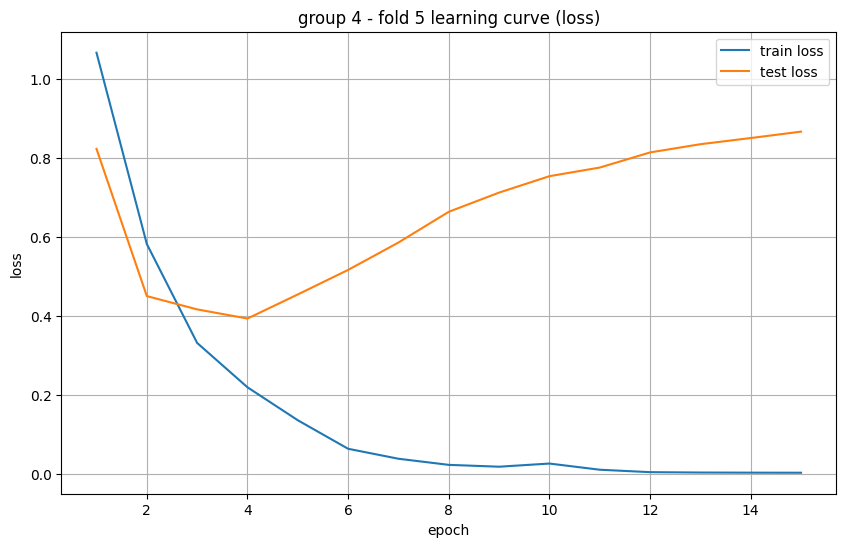

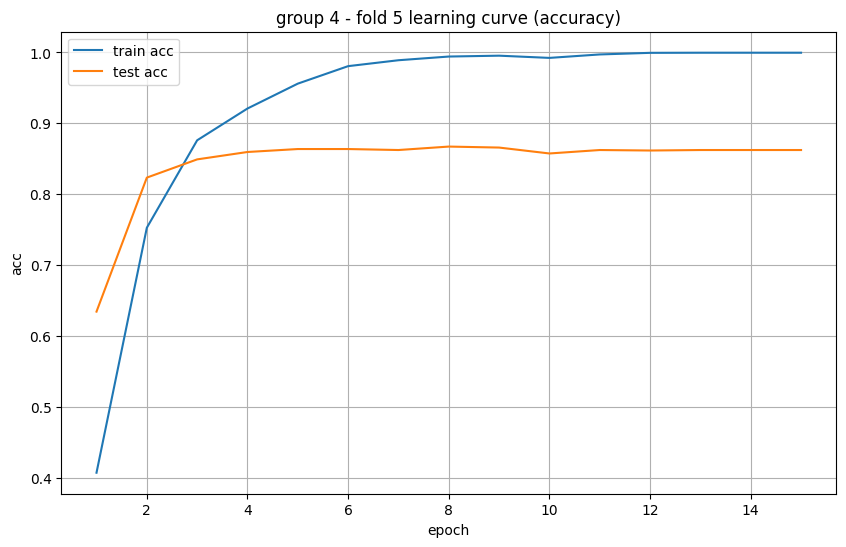

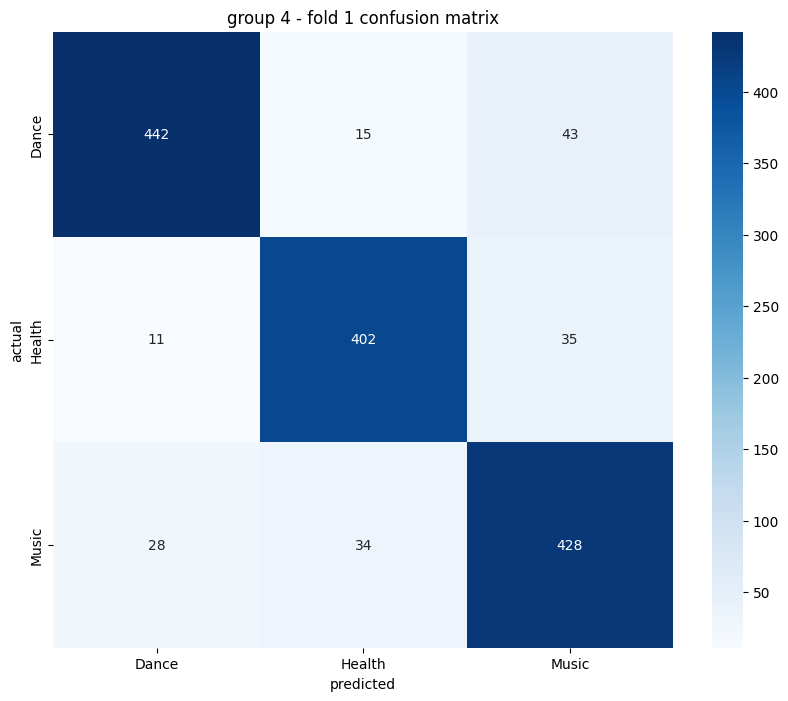

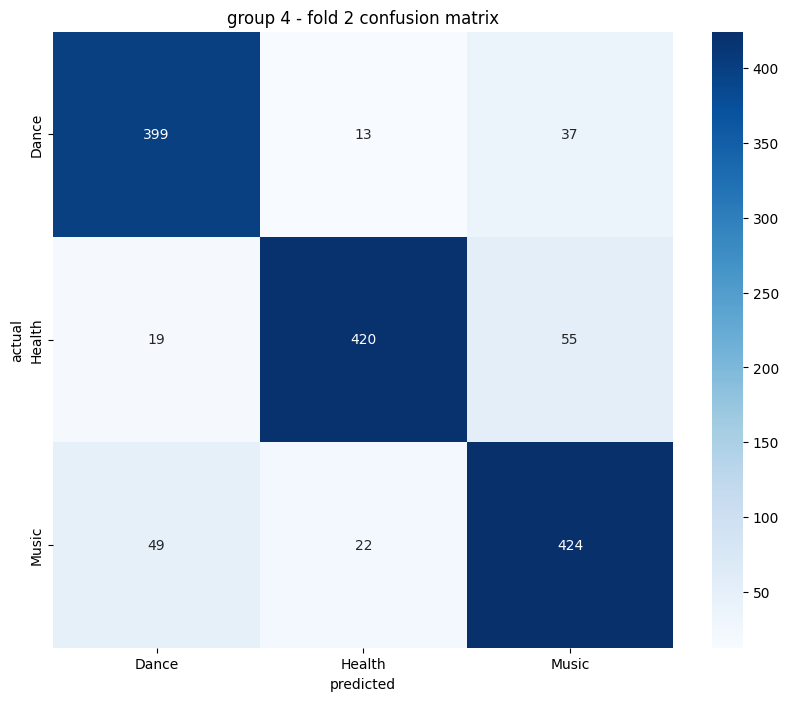

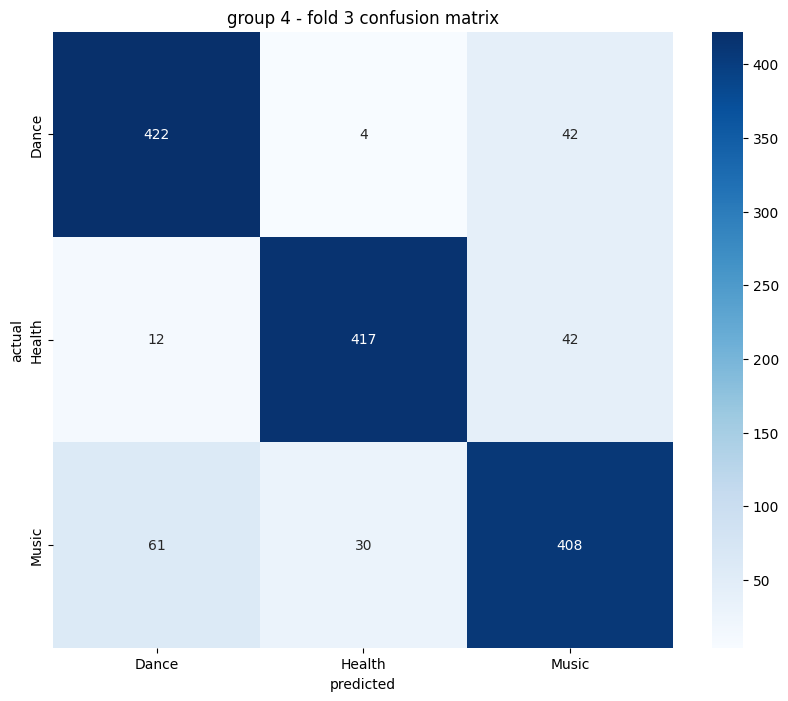

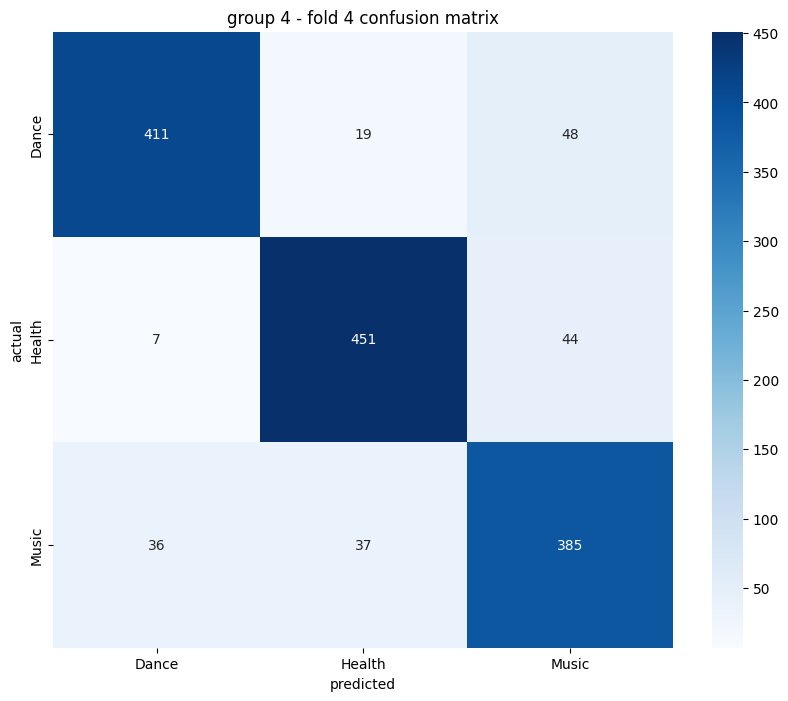

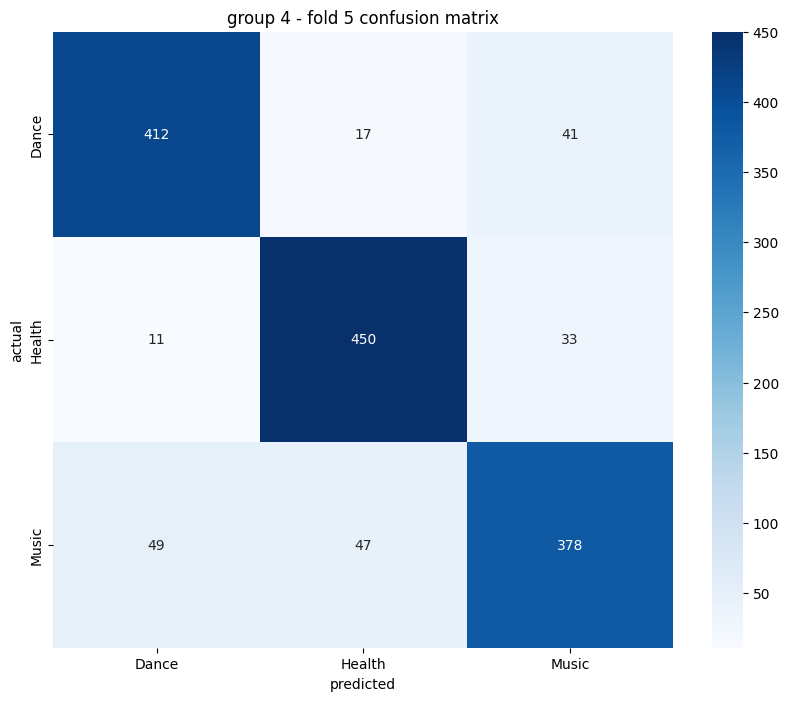


group 5 처리 중...

  fold 1/5 처리 중...
    epoch 1/15: train loss: 1.0012, train acc: 0.4946
                               test loss: 0.8261, test acc: 0.6467
    epoch 5/15: train loss: 0.2633, train acc: 0.9123
                               test loss: 0.5607, test acc: 0.7955
    epoch 10/15: train loss: 0.0669, train acc: 0.9816
                               test loss: 0.9816, test acc: 0.7872
    epoch 15/15: train loss: 0.0175, train acc: 0.9963
                               test loss: 1.2394, test acc: 0.7837

  fold 2/5 처리 중...
    epoch 1/15: train loss: 1.0660, train acc: 0.4094
                               test loss: 0.9296, test acc: 0.5563
    epoch 5/15: train loss: 0.2696, train acc: 0.9111
                               test loss: 0.5682, test acc: 0.8004
    epoch 10/15: train loss: 0.0574, train acc: 0.9864
                               test loss: 0.9925, test acc: 0.7754
    epoch 15/15: train loss: 0.0235, train acc: 0.9958
                               test lo

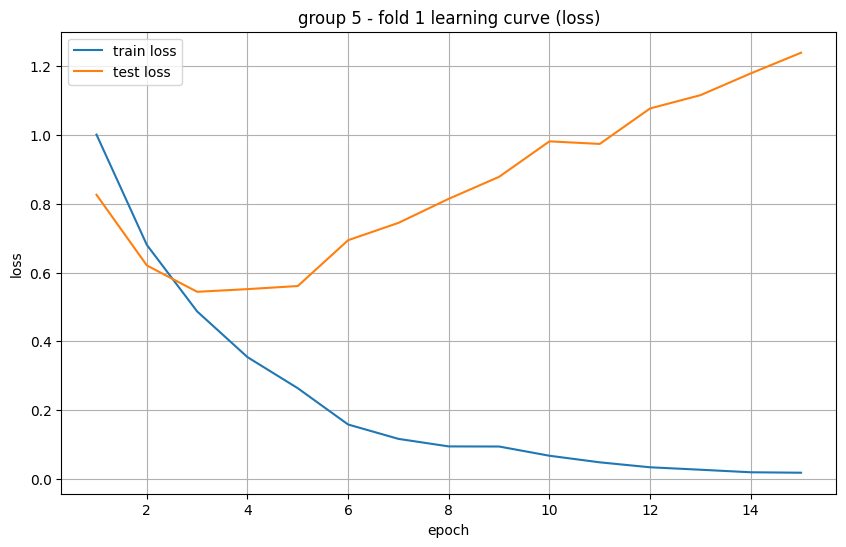

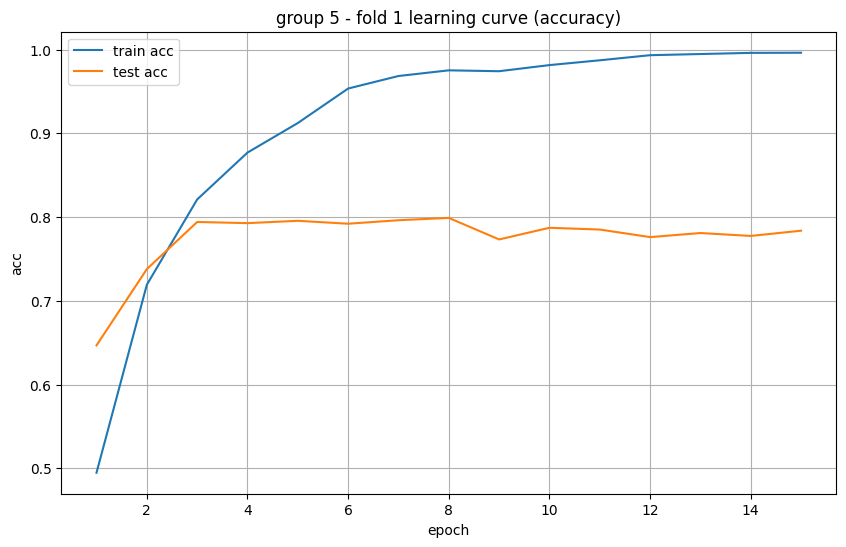

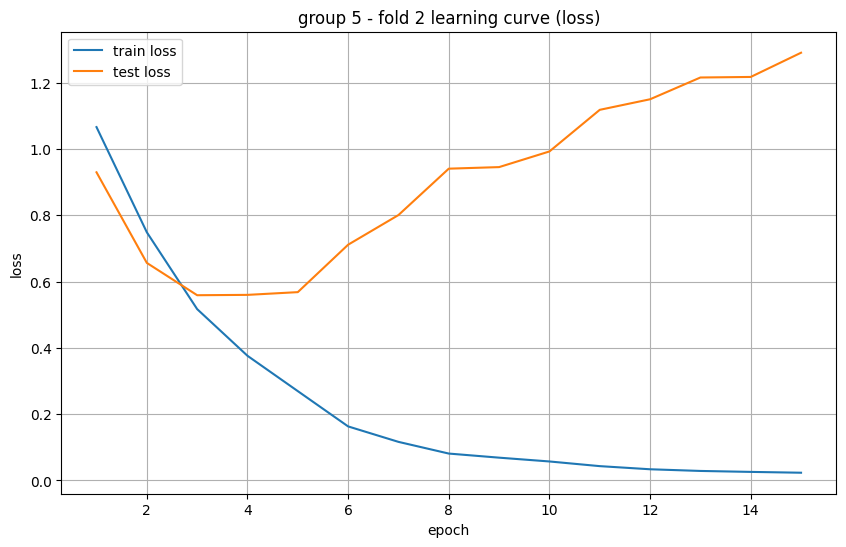

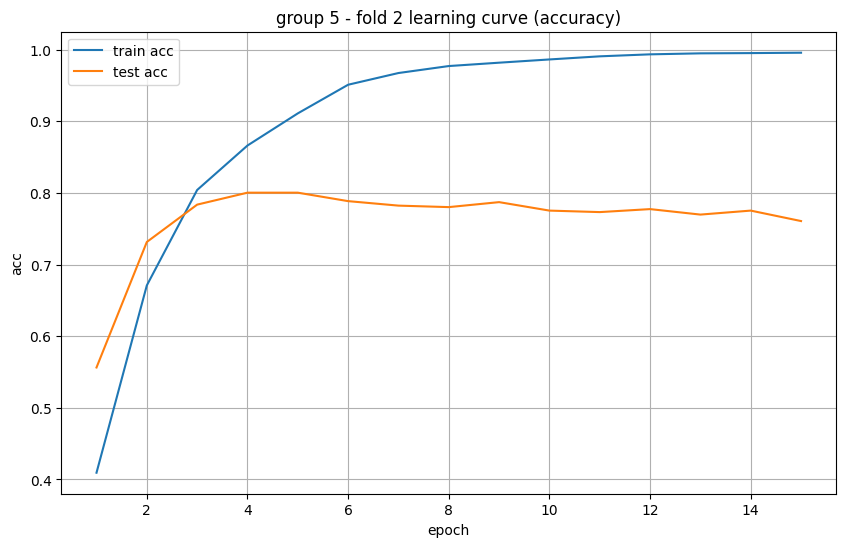

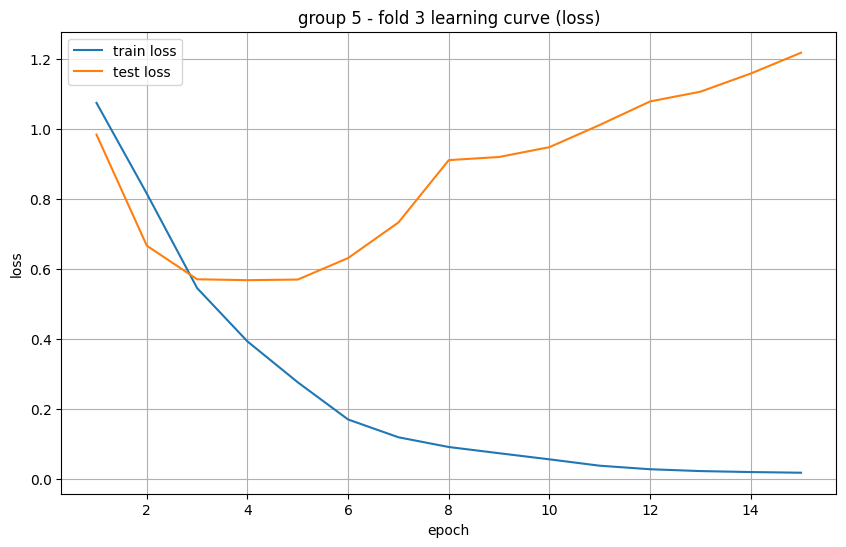

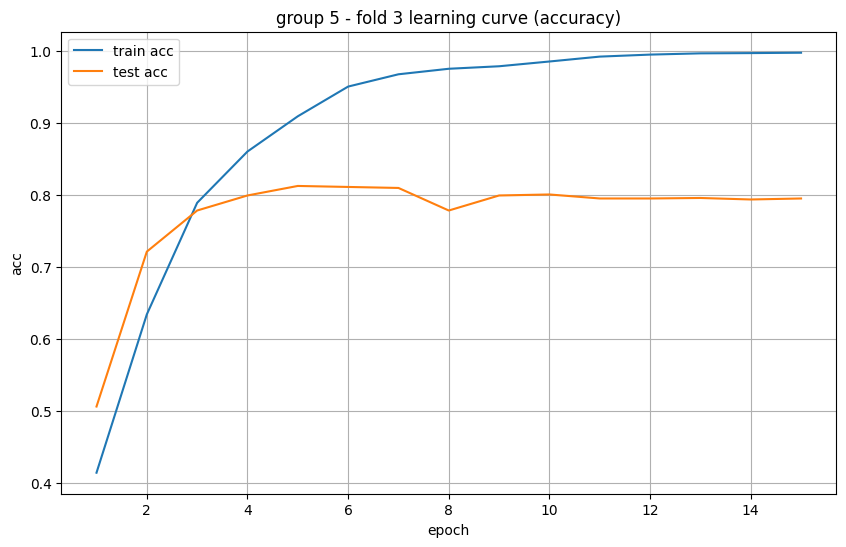

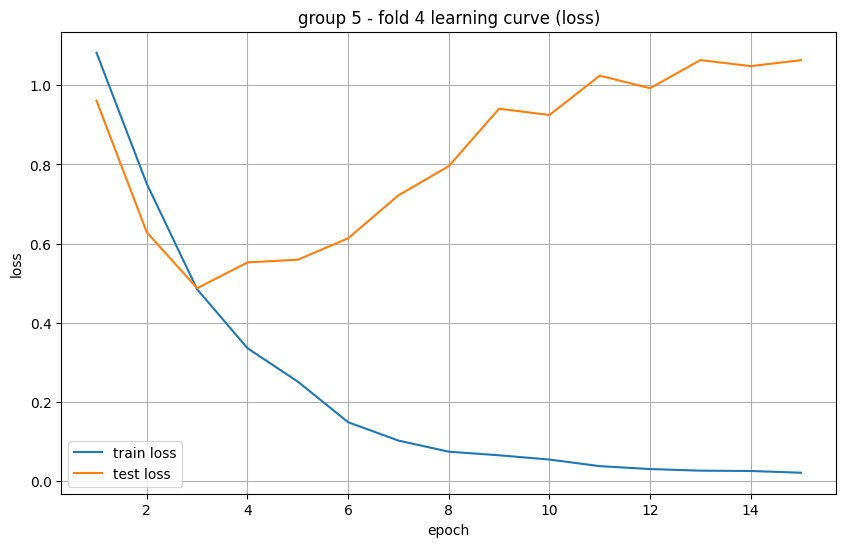

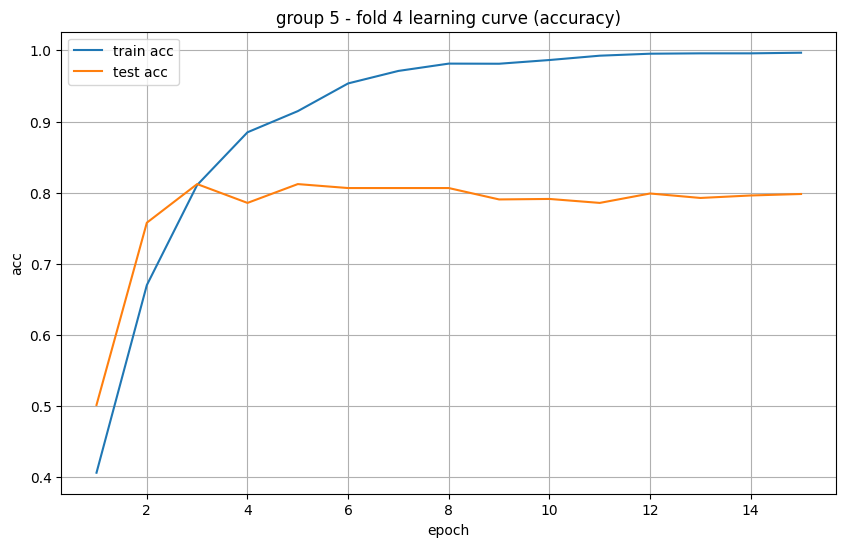

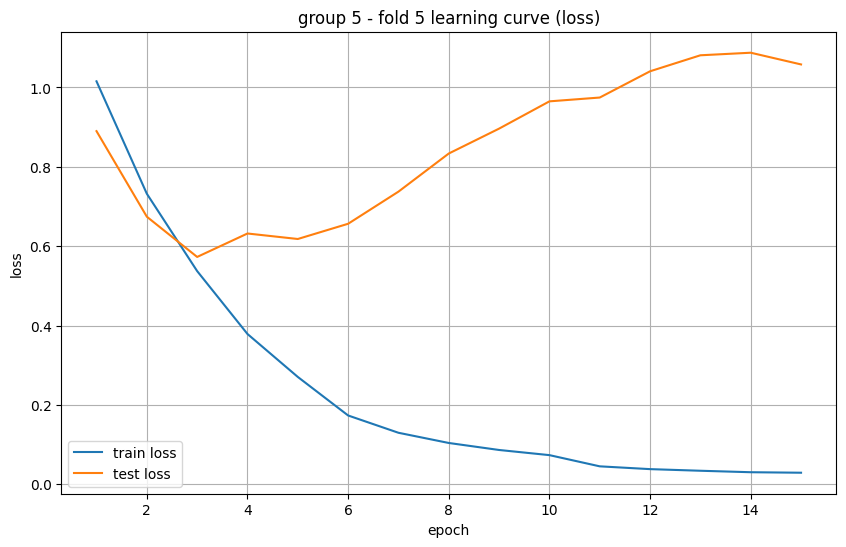

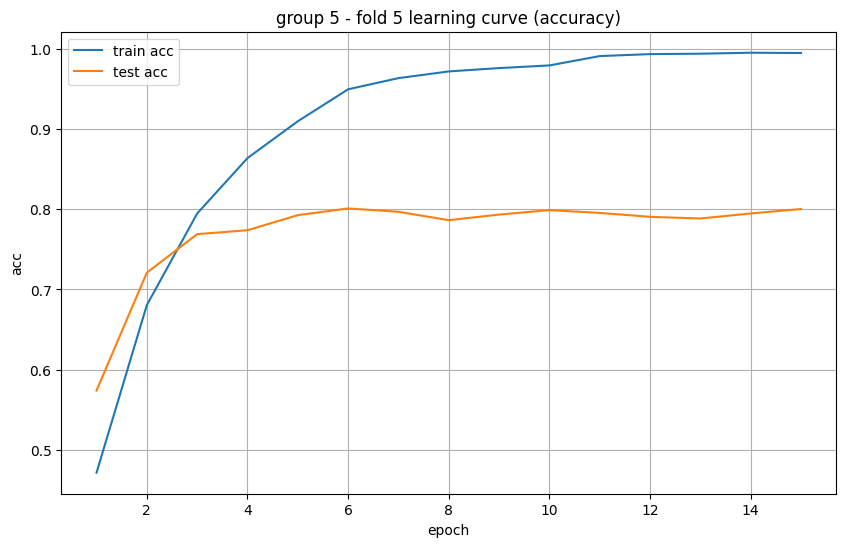

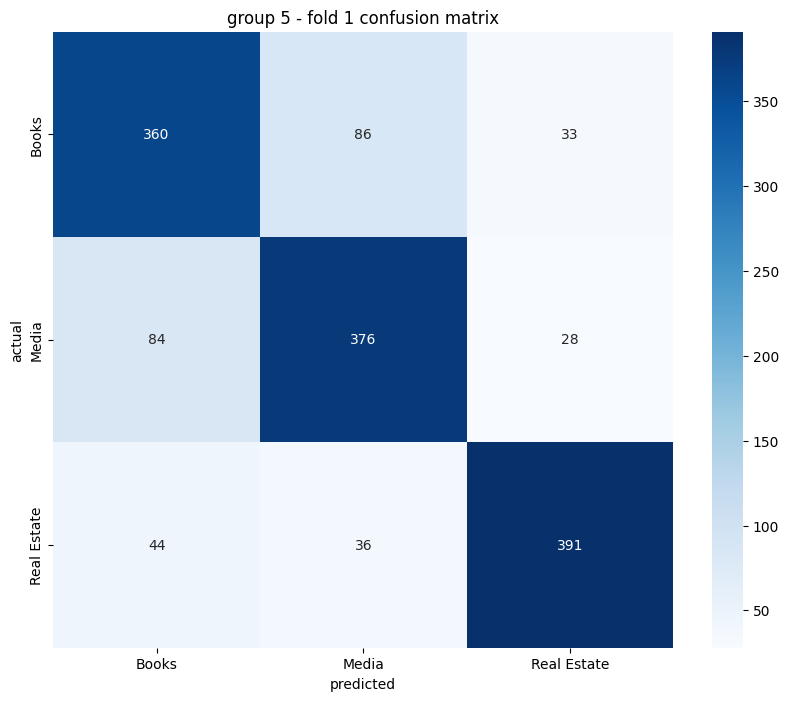

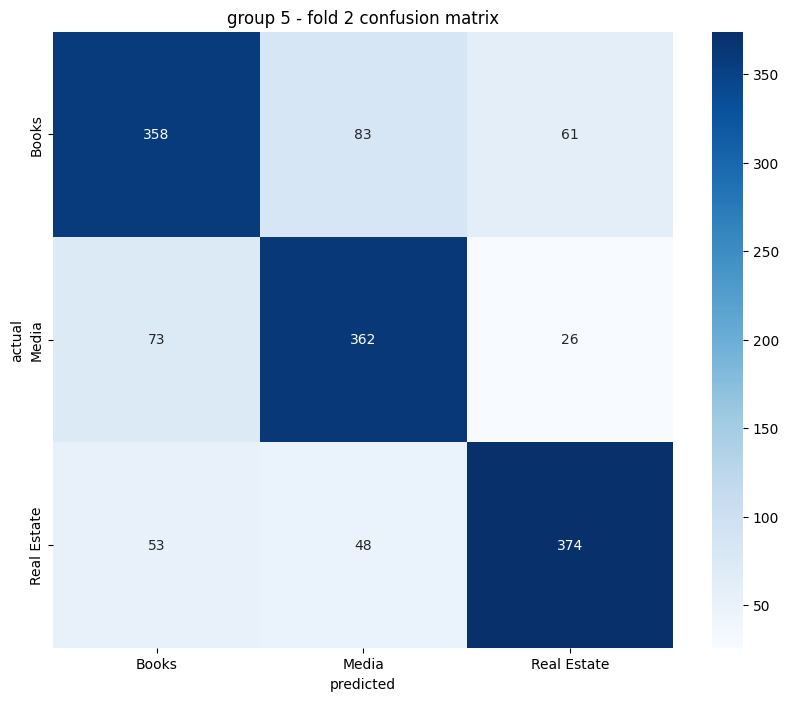

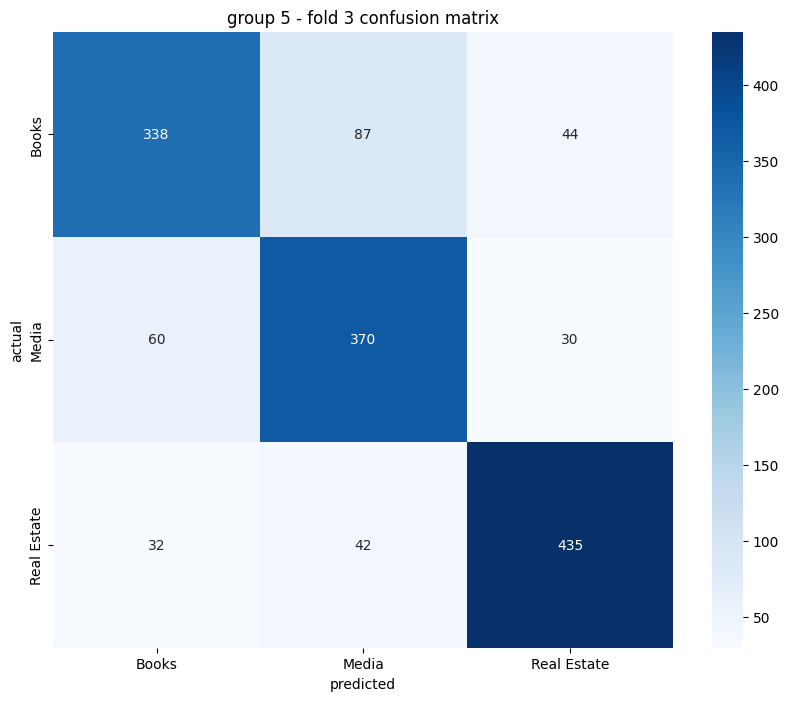

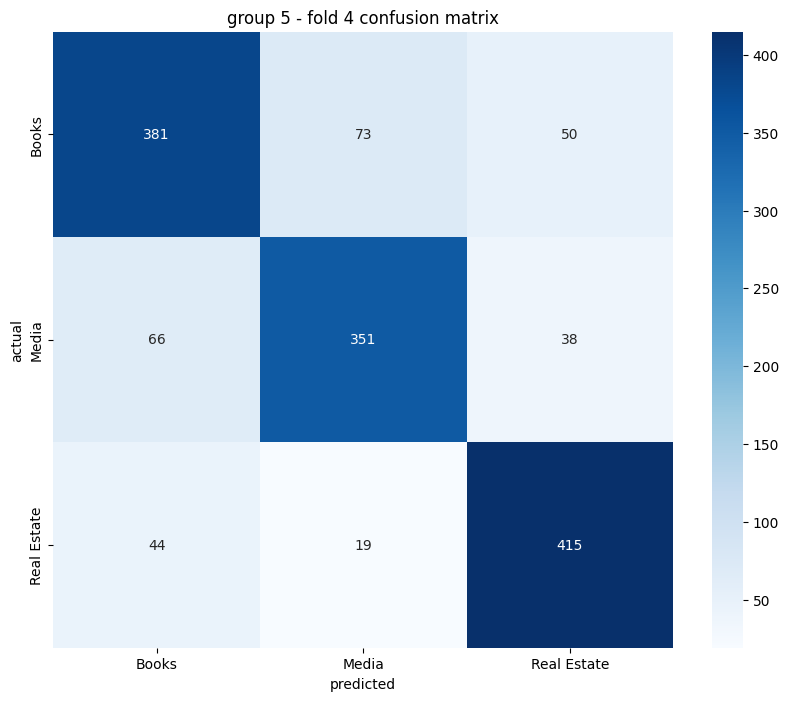

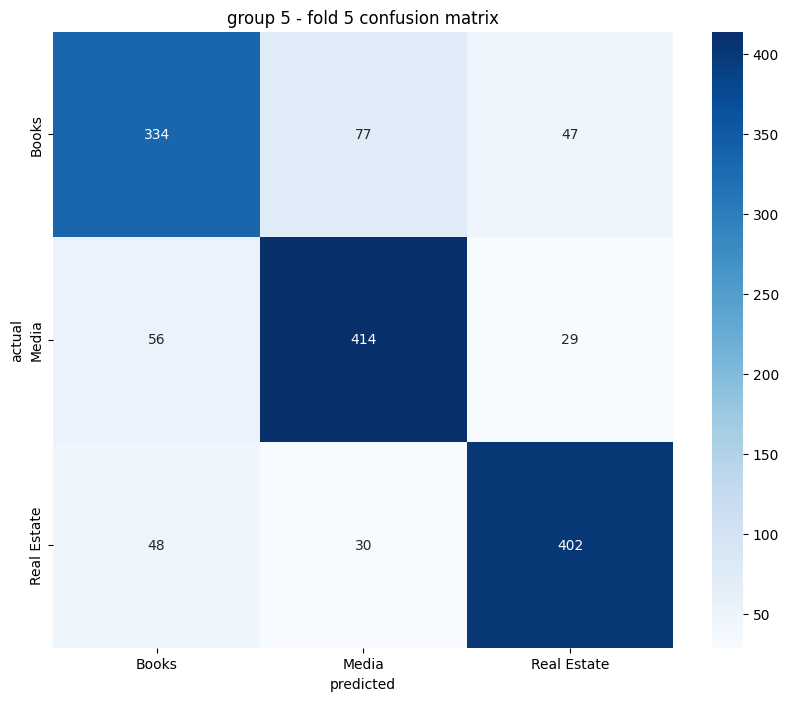


group 6 처리 중...

  fold 1/5 처리 중...
    epoch 1/15: train loss: 0.8793, train acc: 0.5693
                               test loss: 0.6705, test acc: 0.7514
    epoch 5/15: train loss: 0.1675, train acc: 0.9491
                               test loss: 0.3799, test acc: 0.8875
    epoch 10/15: train loss: 0.0258, train acc: 0.9932
                               test loss: 0.6141, test acc: 0.8708
    epoch 15/15: train loss: 0.0111, train acc: 0.9986
                               test loss: 0.6301, test acc: 0.8826

  fold 2/5 처리 중...
    epoch 1/15: train loss: 0.9242, train acc: 0.5476
                               test loss: 0.6031, test acc: 0.7903
    epoch 5/15: train loss: 0.2435, train acc: 0.9213
                               test loss: 0.4156, test acc: 0.8688
    epoch 10/15: train loss: 0.0627, train acc: 0.9823
                               test loss: 0.6474, test acc: 0.8500
    epoch 15/15: train loss: 0.0178, train acc: 0.9960
                               test lo

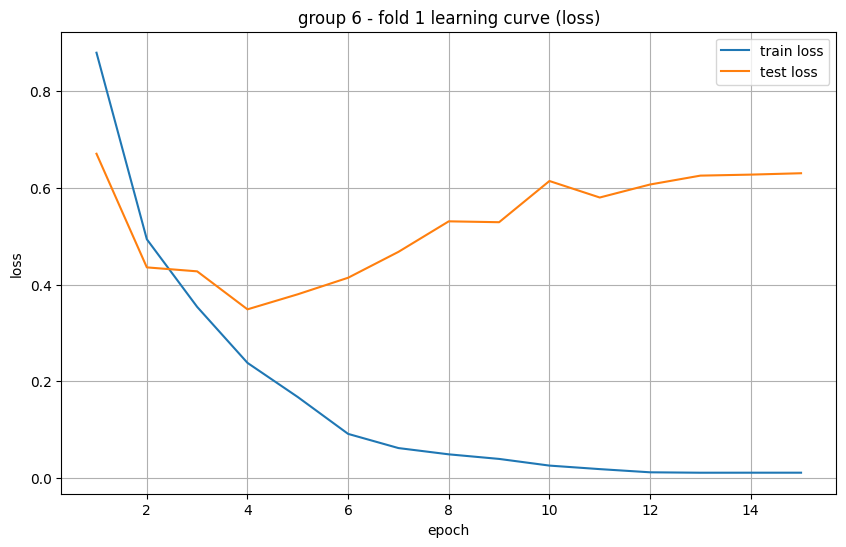

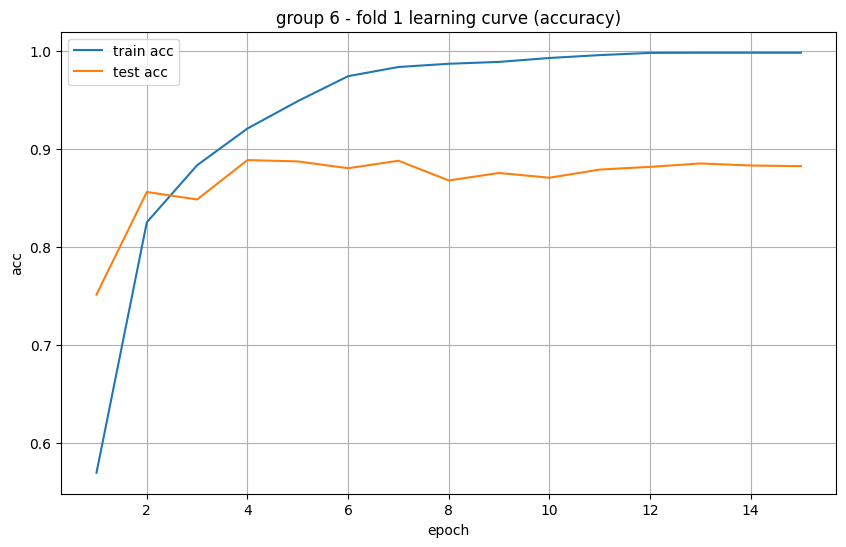

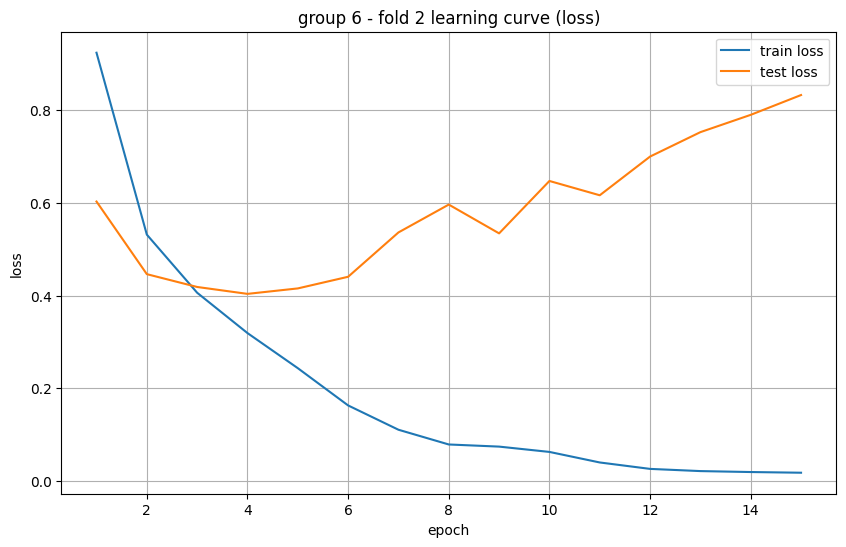

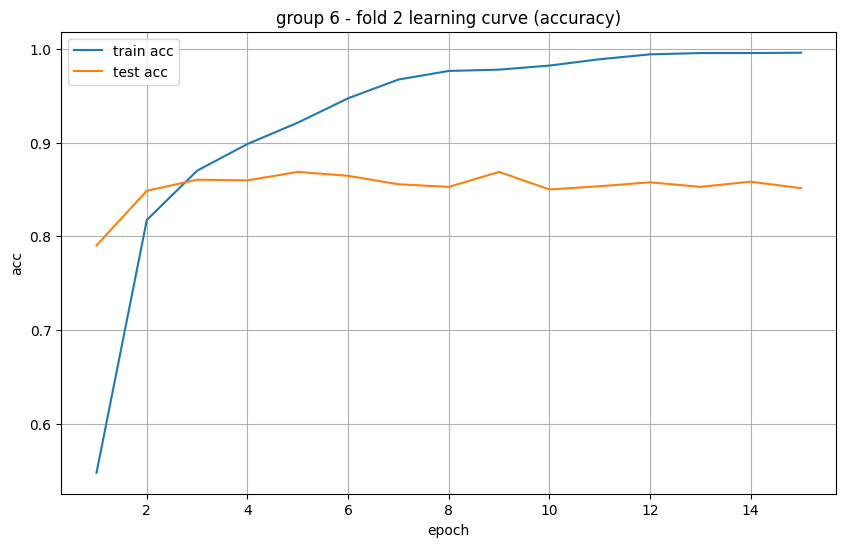

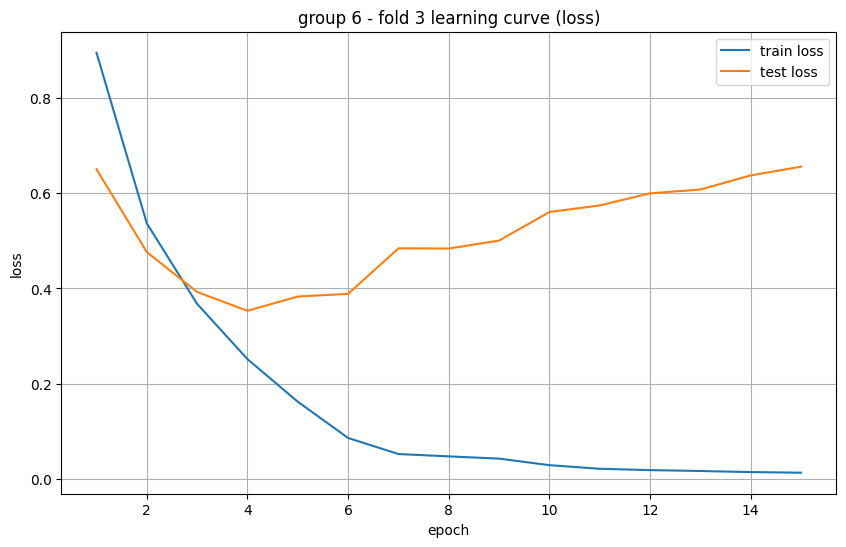

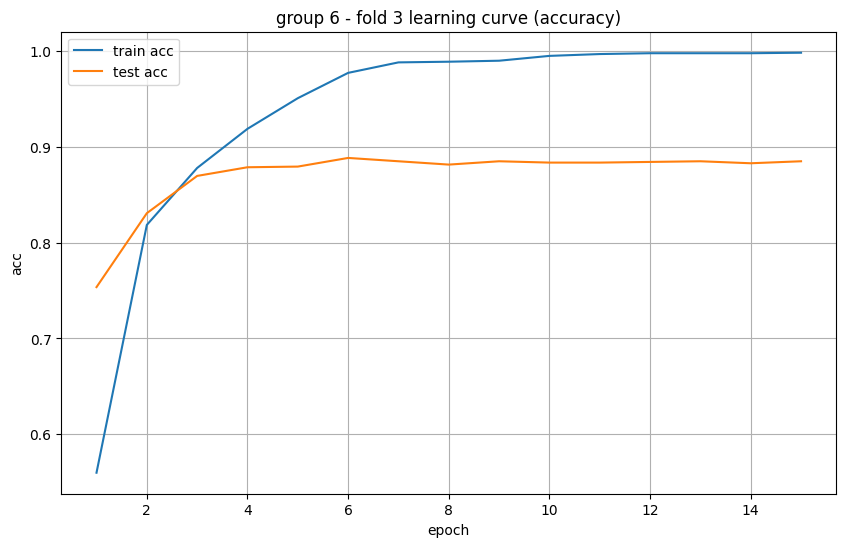

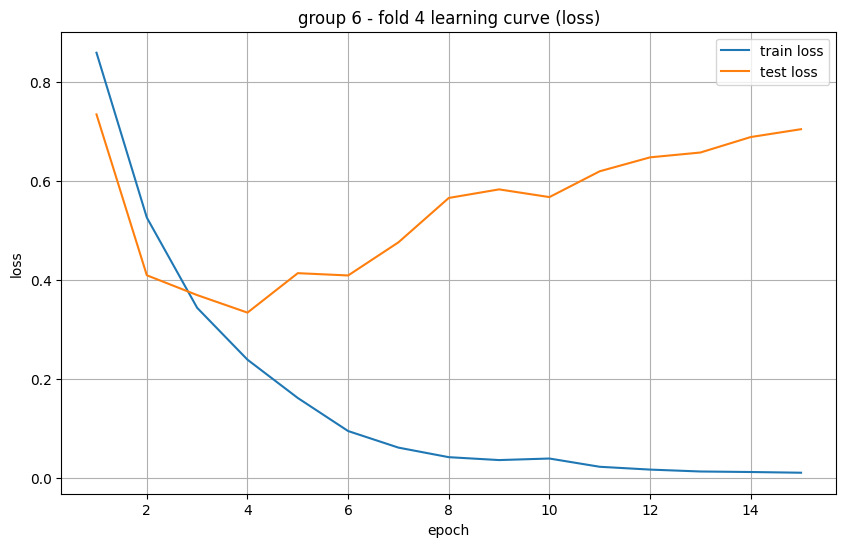

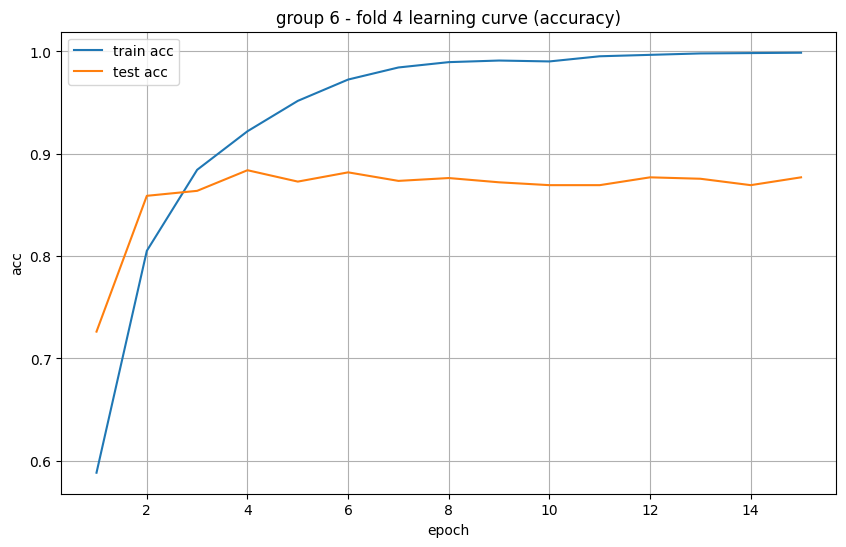

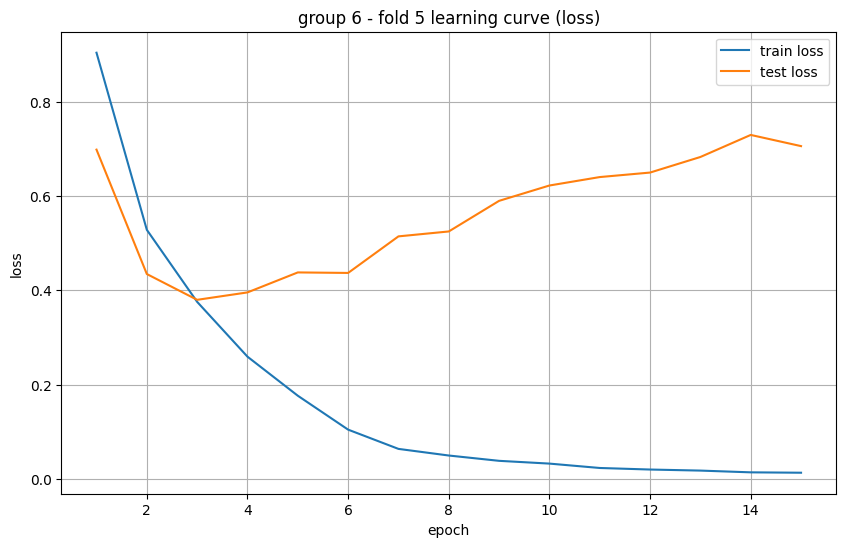

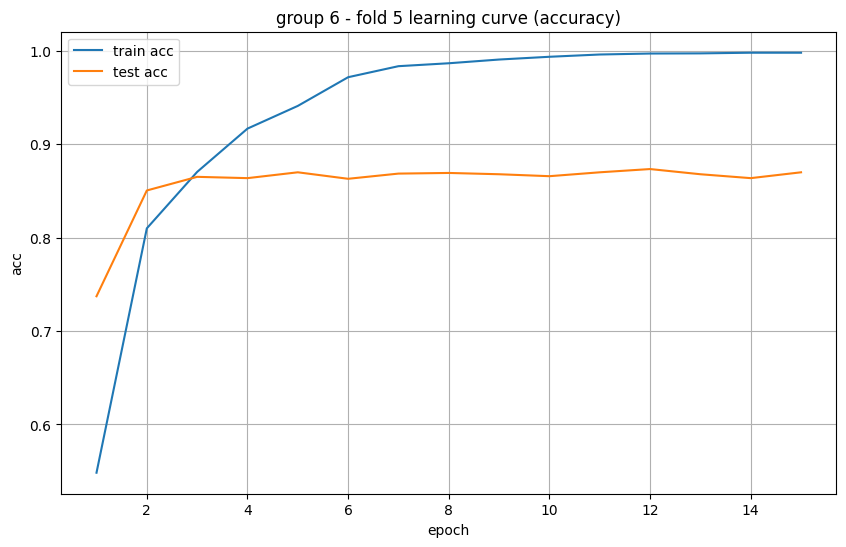

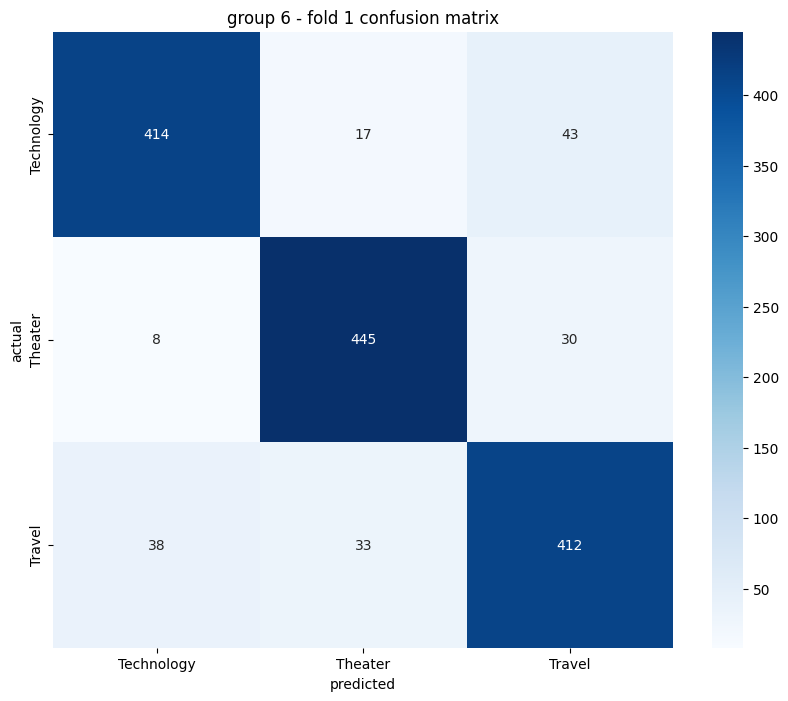

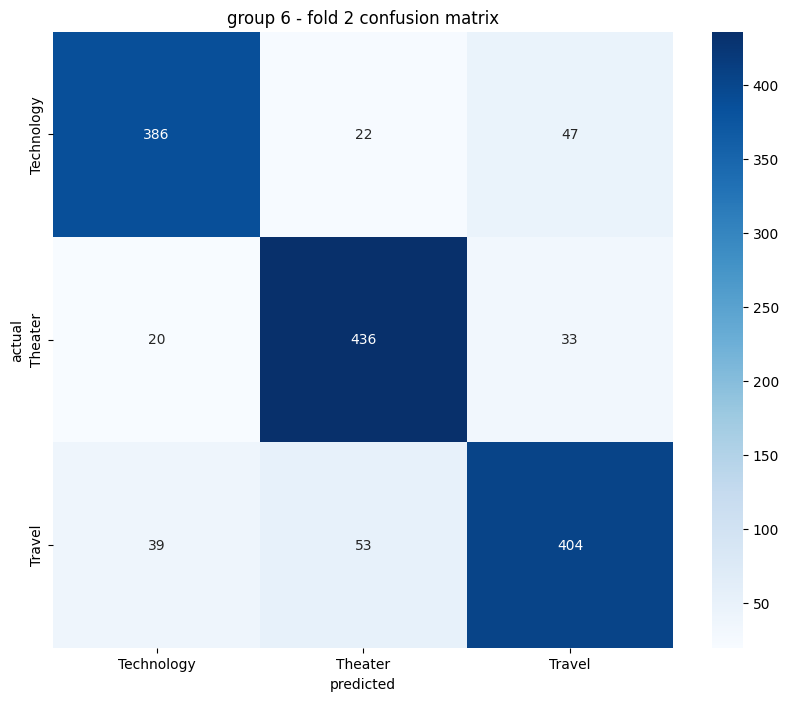

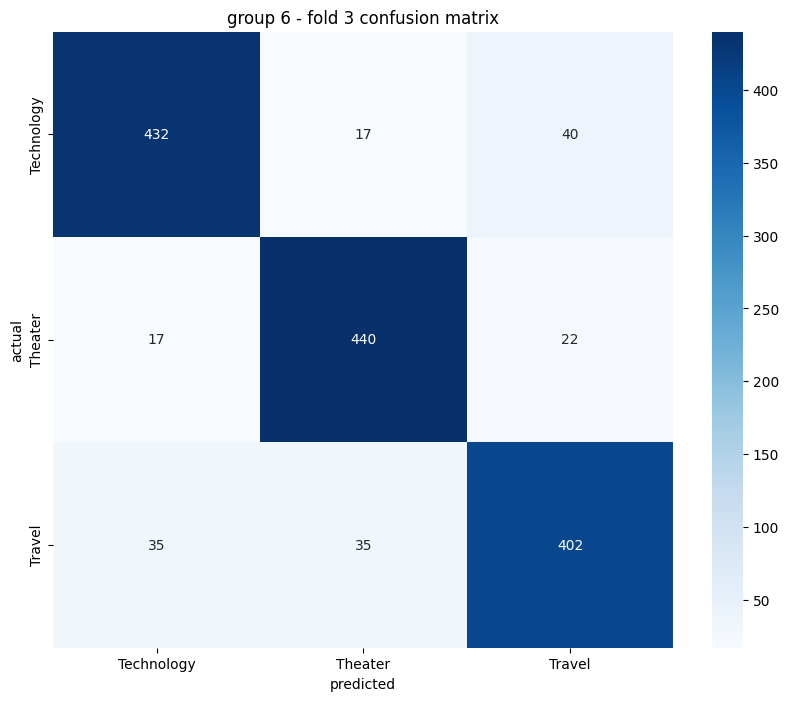

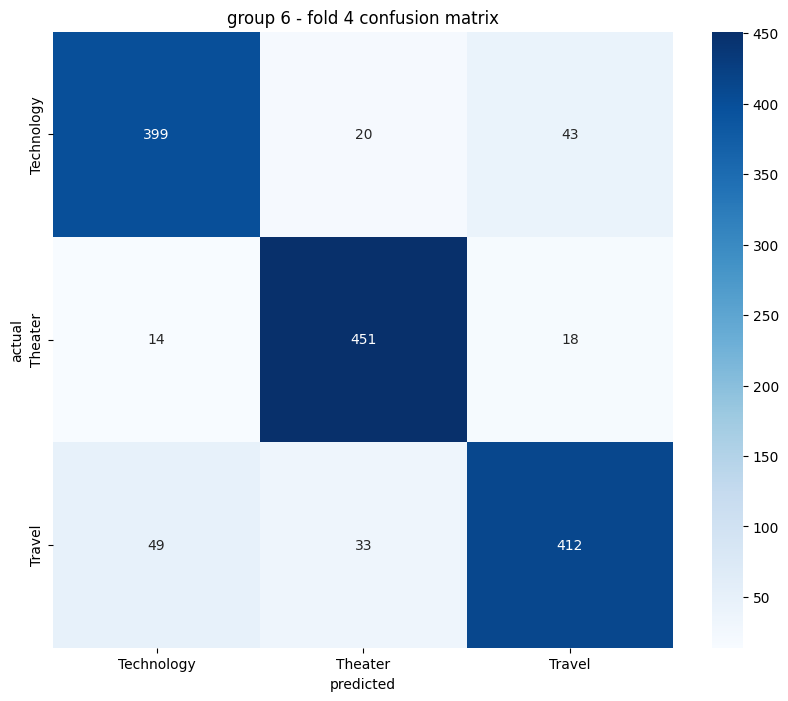

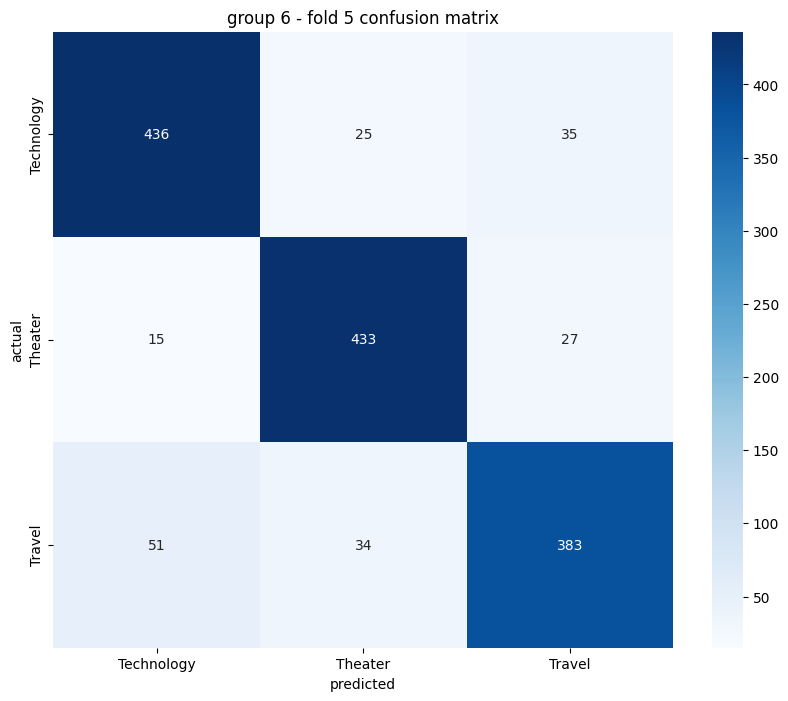


=== 모든 그룹의 요약 결과 ===

그룹 1 - 평균 테스트 정확도: 0.8518
  폴드 1: 테스트 정확도 = 0.8454
  폴드 2: 테스트 정확도 = 0.8695
  폴드 3: 테스트 정확도 = 0.8328
  폴드 4: 테스트 정확도 = 0.8619
  폴드 5: 테스트 정확도 = 0.8494

그룹 2 - 평균 테스트 정확도: 0.7963
  폴드 1: 테스트 정확도 = 0.8064
  폴드 2: 테스트 정확도 = 0.7897
  폴드 3: 테스트 정확도 = 0.7988
  폴드 4: 테스트 정확도 = 0.7986
  폴드 5: 테스트 정확도 = 0.7882

그룹 3 - 평균 테스트 정확도: 0.8101
  폴드 1: 테스트 정확도 = 0.8165
  폴드 2: 테스트 정확도 = 0.8136
  폴드 3: 테스트 정확도 = 0.7964
  폴드 4: 테스트 정확도 = 0.8056
  폴드 5: 테스트 정확도 = 0.8185

그룹 4 - 평균 테스트 정확도: 0.8691
  폴드 1: 테스트 정확도 = 0.8846
  폴드 2: 테스트 정확도 = 0.8644
  폴드 3: 테스트 정확도 = 0.8672
  폴드 4: 테스트 정확도 = 0.8672
  폴드 5: 테스트 정확도 = 0.8623

그룹 5 - 평균 테스트 정확도: 0.7876
  폴드 1: 테스트 정확도 = 0.7837
  폴드 2: 테스트 정확도 = 0.7608
  폴드 3: 테스트 정확도 = 0.7949
  폴드 4: 테스트 정확도 = 0.7982
  폴드 5: 테스트 정확도 = 0.8003

그룹 6 - 평균 테스트 정확도: 0.8732
  폴드 1: 테스트 정확도 = 0.8826
  폴드 2: 테스트 정확도 = 0.8514
  폴드 3: 테스트 정확도 = 0.8847
  폴드 4: 테스트 정확도 = 0.8770
  폴드 5: 테스트 정확도 = 0.8700


In [19]:
EPOCHS = 15
BATCH_SIZE = 32
K_FOLDS = 5
results = []
VOCAB_SIZE = tokenizer.vocab_size
EMBED_DIM = 128
LATENT_DIM = 64
LATENT_SIZE = 64  # Latent의 수
NUM_BLOCKS = 4    # PerceiverBlock의 수

all_learning_curves = []
best_models = {} 

for idx, group_file in enumerate(output_paths, start=1):
    print(f"\ngroup {idx} 처리 중...")

    df = pd.read_csv(group_file)
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])
    num_classes = len(label_encoder.classes_)

    input_ids, attention_masks = tokenize_data(df, tokenizer=tokenizer, MAX_LENGTH=MAX_LENGTH)
    labels = torch.tensor(df['Label'].values)

    dataset = CustomDataset(input_ids, attention_masks, labels)

    kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

    fold_results = []
    fold_learning_curves = []
    best_fold_acc = 0.0
    best_model = None
    best_valid_loader = None

    for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset), start=1):
        print(f"\n  fold {fold}/{K_FOLDS} 처리 중...")

        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)

        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

        perceiver = Perceiver(
            input_dim=EMBED_DIM,
            latent_dim=LATENT_DIM,
            latent_size=LATENT_SIZE,
            num_classes=num_classes,
            num_blocks=NUM_BLOCKS,
            self_attn_layers_per_block=1
        )

        model = CombinedModel(
            vocab_size=VOCAB_SIZE,
            embed_dim=EMBED_DIM,
            perceiver_model=perceiver
        )
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-3)  
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        train_losses, test_losses = [], []
        train_accuracies, test_accuracies = [], []

        for epoch in range(EPOCHS):
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            test_loss, test_acc = eval_epoch(model, test_loader, criterion, device)

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

            scheduler.step()

            current_lr = scheduler.get_last_lr()[0]
            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f'    epoch {epoch+1}/{EPOCHS}: train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')
                print(f'                               test loss: {test_loss:.4f}, test acc: {test_acc:.4f}')
        if test_acc > best_fold_acc:
            best_fold_acc = test_acc
            best_model = model
            best_valid_loader = test_loader

        fold_learning_curves.append({
            "Fold": fold,
            "train_losses": train_losses,
            "test_losses": test_losses,
            "train_accuracies": train_accuracies,
            "test_accuracies": test_accuracies
        })

        
        y_true, y_pred = [], []
        model.eval()
        with torch.no_grad():
            for batch in test_loader:
                input_ids_batch = batch['input_ids'].to(device)
                attention_mask_batch = batch['attention_mask'].to(device)  
                labels_batch = batch['labels'].to(device)

                outputs = model(input_ids_batch)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels_batch.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        cm = confusion_matrix(y_true, y_pred)
        report = classification_report(y_true, y_pred, output_dict=True)
        fold_results.append({
            "Fold": fold,
            "Test Accuracy": test_acc,
            "Confusion Matrix": cm,
            "Classification Report": report
        })
    

    # 모델 및 데이터로더 저장장
    model_save_path = f"{model_path}/text_model_{idx}.pkl"
    torch.save(best_model, model_save_path)
    print(f"Group {idx} 최고 모델 저장 완료: {model_save_path}")

    val_loader_save_path = f"{loader_path}/text_val_loader_{idx}.pkl"
    with open(val_loader_save_path, 'wb') as f:
        pickle.dump(best_valid_loader, f) 
    print(f"Group {idx} 최고 valid loader 저장 완료: {val_loader_save_path}")
    
    
    # 결과 Analysis
    avg_accuracy = np.mean([fr["Test Accuracy"] for fr in fold_results])
    results.append({
        "Group": idx,
        "Average Test Accuracy": avg_accuracy,
        "Fold Results": fold_results
    })

    all_learning_curves.append({
        "Group": idx,
        "Fold Learning Curves": fold_learning_curves
    })

  
    print(f"\n그룹 {idx}의 {K_FOLDS} 폴드 평균 테스트 정확도: {avg_accuracy:.4f}")

    for fold_result in fold_results:
        print(f"\n  폴드 {fold_result['Fold']} 결과:")
        print(f"    테스트 정확도: {fold_result['Test Accuracy']:.4f}")
        print(pd.DataFrame(fold_result['Classification Report']).transpose())

    for curve in fold_learning_curves:
        fold_idx = curve["Fold"]

        
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_losses"], label="train loss")
        plt.plot(range(1, EPOCHS + 1), curve["test_losses"], label="test loss")
        plt.title(f"group {idx} - fold {fold_idx} learning curve (loss)")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend()
        plt.grid(True)
        plt.show()

   
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_accuracies"], label="train acc")
        plt.plot(range(1, EPOCHS + 1), curve["test_accuracies"], label="test acc")
        plt.title(f"group {idx} - fold {fold_idx} learning curve (accuracy)")
        plt.xlabel("epoch")
        plt.ylabel("acc")
        plt.legend()
        plt.grid(True)
        plt.show()

    
    for fold_result in fold_results:
        fold_idx = fold_result["Fold"]
        cm = fold_result["Confusion Matrix"]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=label_encoder.classes_, 
                    yticklabels=label_encoder.classes_)
        plt.title(f"group {idx} - fold {fold_idx} confusion matrix")
        plt.xlabel("predicted")
        plt.ylabel("actual")
        plt.show()

print("\n=== 모든 그룹의 요약 결과 ===")
for result in results:
    group_idx = result["Group"]
    avg_acc = result["Average Test Accuracy"]
    print(f"\n그룹 {group_idx} - 평균 테스트 정확도: {avg_acc:.4f}")
    for fold_result in result["Fold Results"]:
        fold_idx = fold_result["Fold"]
        fold_acc = fold_result["Test Accuracy"]
        print(f"  폴드 {fold_idx}: 테스트 정확도 = {fold_acc:.4f}")